# **TREATMENT RECOMMENDATION USING LARGE LANGUAGE MODEL PERSONALIZATION**

In [ ]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7425febfb8dc9d74124f2e72109ffc2456f5eeb080f6c6a7212f63128d76f7be
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import warnings

import os
import wget
import time
import datetime
import random

import numpy as np
import pandas as pd

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Download Dataset

In [ ]:
print("Downloading drugsCom Dataset")

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip'

if not os.path.exists("./drugsCom_raw.zip"):
    wget.download(url, "./drugsCom_raw.zip")

In [ ]:
if not os.path.exists("./drugsCom_raw/"):
    !unzip drugsCom_raw.zip

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


### Sample Data

In [ ]:
df = pd.read_csv("./drugsComTrain_raw.tsv", delimiter = "\t", header = 0, names = [None, "drugName", "condition", "review", "rating", "date", "usefulCount"])

print("The number of training samples are {:,}\n".format(df.shape[0]))
df.head()

The number of training samples are 161,297



None                  drugName                     condition  \
0  206461                 Valsartan  Left Ventricular Dysfunction   
1   95260                Guanfacine                          ADHD   
2   92703                    Lybrel                 Birth Control   
3  138000                Ortho Evra                 Birth Control   
4   35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [ ]:
# describing the data

df.describe()

None         rating    usefulCount
count  161297.000000  161297.000000  161297.000000
mean   115923.585305       6.994377      28.004755
std     67004.445170       3.272329      36.403742
min         2.000000       1.000000       0.000000
25%     58063.000000       5.000000       6.000000
50%    115744.000000       8.000000      16.000000
75%    173776.000000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000

<ipython-input-7-71829aabb66f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')


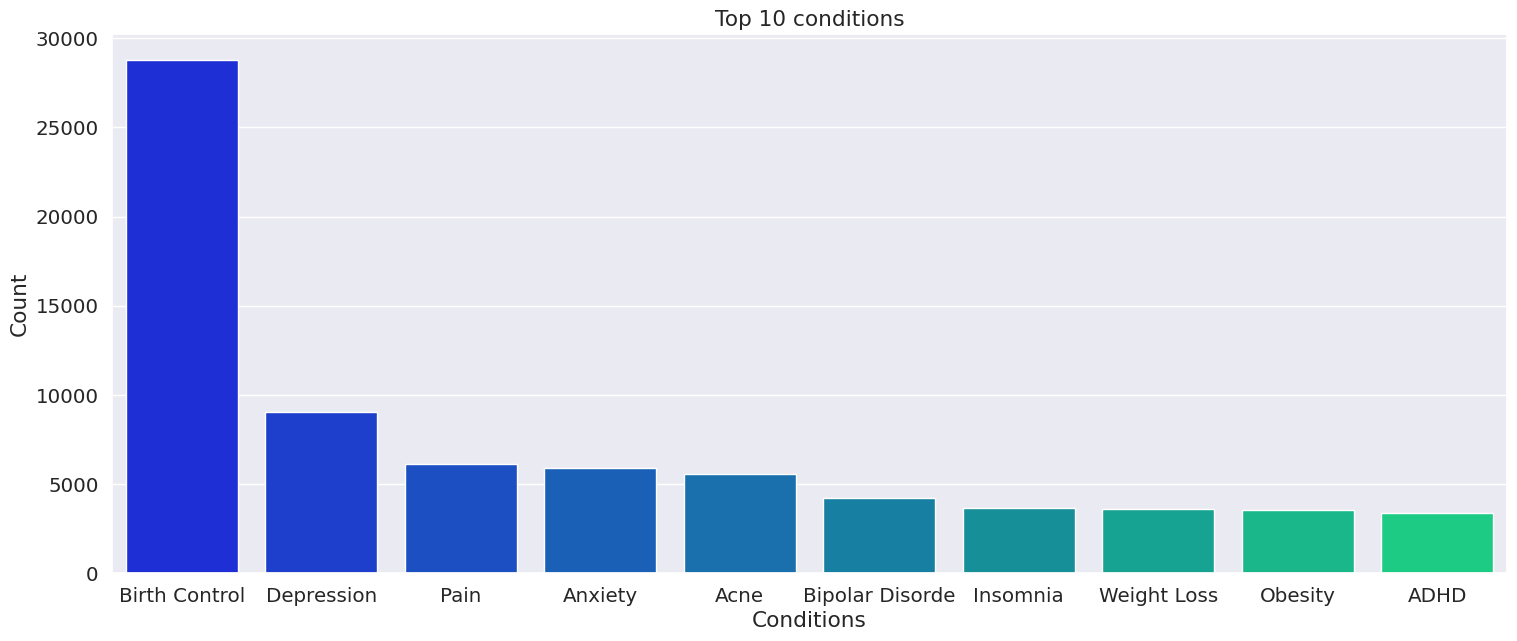

In [ ]:

 #This barplot show the top 10 conditions the people are suffering.
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

### Retrieve Features

In [ ]:
print("Retrieving Features Dataset")

sentences = df.review.values
labels = df['rating']
drug_name = df.drugName.values
condition = df.condition.values

Retrieving Features Dataset


### Label Encoding

In [ ]:
labels = labels.apply(lambda x: 1 if x >= 5.0 else 0)
labels = np.asarray(labels)

print("Encoding Labels")

Encoding Labels


### Bert Tokenizer

In [ ]:
print('Downloading BERT tokenizer...')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Tokenization

In [ ]:
warnings.filterwarnings("ignore")

input_ids = []
attention_mask = []

for s in sentences:

    input_encoded = tokenizer.encode_plus(
                        s,
                        add_special_tokens = True,
                        max_length = 64,
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(input_encoded['input_ids'])

    attention_mask.append(input_encoded['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_mask = torch.cat(attention_mask, dim=0)
labels = torch.tensor(labels)

print('Tokenization Done')

Tokenization Done


### Dataset Split

In [ ]:
dfs = TensorDataset(input_ids, attention_mask, labels)

size_train = int(0.9 * len(dfs))
size_val = len(dfs) - size_train

train_data, val_data = random_split(dfs, [size_train, size_val])

print("{:,} is the training dataset size".format(size_train))
print("{:,} is the validation dataset size".format(size_val))

145,167 is the training dataset size
16,130 is the validation dataset size


In [ ]:
# describing the data

df.describe()

None         rating    usefulCount
count  161297.000000  161297.000000  161297.000000
mean   115923.585305       6.994377      28.004755
std     67004.445170       3.272329      36.403742
min         2.000000       1.000000       0.000000
25%     58063.000000       5.000000       6.000000
50%    115744.000000       8.000000      16.000000
75%    173776.000000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000

### Batch Sampling

In [ ]:
bs = 100

train_dl = DataLoader(
            train_data,
            sampler = RandomSampler(train_data),
            batch_size = bs
)

valid_dl = DataLoader(
            val_data,
            sampler = SequentialSampler(val_data),
            batch_size = bs
)

print("Batch Sampling Done")

Batch Sampling Done


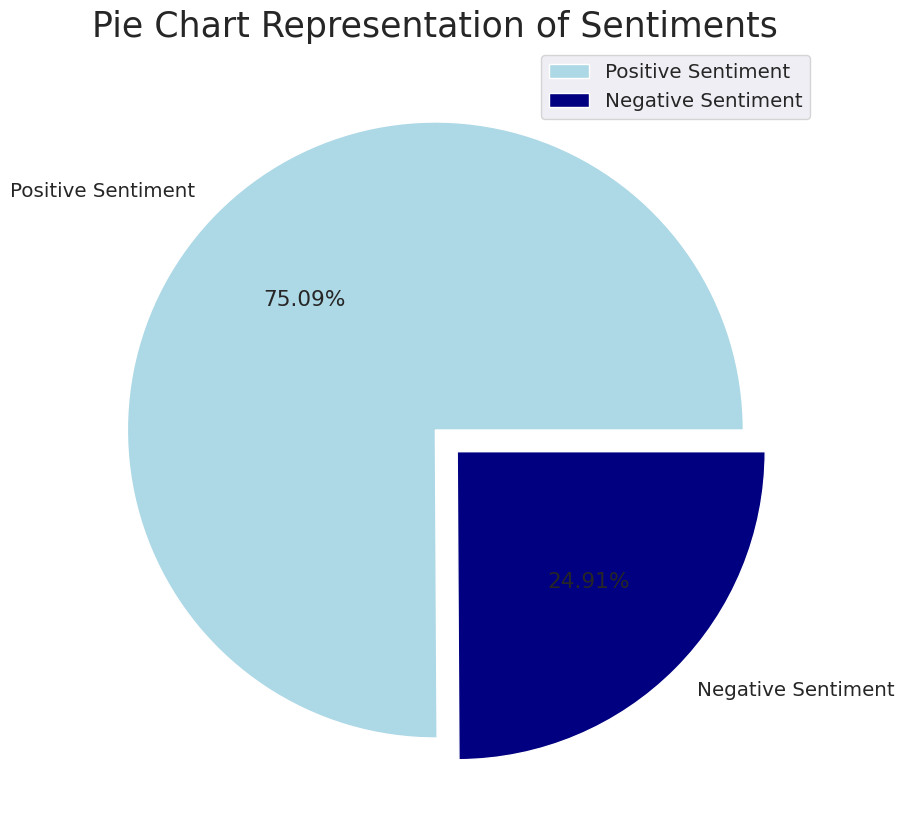

In [ ]:
#a pie chart to represent the sentiments of the patients

size = [161491, 53572]
colors = ['lightblue', 'navy']
l = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = l, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize = 25)
plt.legend()
plt.show()

### BERT Model

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mod = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

mod.to(dev)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Optimizer

In [ ]:
opt = AdamW(
    mod.parameters(),
    lr = 3e-5,
    eps = 1e-8
)

print("Optimizer Initialized")

Optimizer Initialized


### Scheduler

In [ ]:
epoch = 3
ts = len(train_dl) * epoch

sch = get_linear_schedule_with_warmup(
    opt,
    num_warmup_steps = 0,
    num_training_steps = ts
)

print("Scheduler Initialized")

Scheduler Initialized


### Accuracy

In [ ]:
def acc(preds, labels):
    preds_flat = np.argmax(preds, axis = -1).flatten()
    labels_flat = labels

    return np.sum(preds_flat == labels_flat)/len(preds_flat)

print("Accuracy Function Defined")

Accuracy Function Defined


### Time

In [ ]:
def t(s):
    p = int(round(s))
    return str(datetime.timedelta(seconds = p))

print("Time Function Defined")

Time Function Defined


### Training and Validation

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

stats = []

tot_t0 = time.time()

for i in range(0, epoch):

    print("\n")
    print("Training epoch {} / {}".format(i + 1, epoch))
    print("Training.......................")
    print("\n")

    t0 = time.time()

    tot_train_loss = 0

    mod.train()

    for s, b in enumerate(train_dl):

        if s % bs == 0 and not s == 0:

            timef = t(time.time() - t0)

            print("Batch {} of {} has elasped in {}".format(s, len(train_dl), timef))

        input_ids_d = b[0].to(dev)
        attention_mask_d = b[1].to(dev)
        labels_d = b[2].to(dev)

        mod.zero_grad()

        cost, logits = mod(
              input_ids = input_ids_d,
              attention_mask = attention_mask_d,
              labels = labels_d,
              token_type_ids = None,
              return_dict = False
        )

        tot_train_loss += cost.item()

        cost.backward()

        torch.nn.utils.clip_grad_norm_(mod.parameters(), 1.0)

        opt.step()

        sch.step()

    avg_tloss = tot_train_loss / len(train_dl)

    train_time = t(time.time() - t0)

    print("\n")
    print("Average Training Loss is {}".format(avg_tloss))
    print("Training Time per epoch is {}".format(train_time))

    print("\n")
    print("Validating.......................")

    t0 = time.time()

    mod.eval()

    tot_eval_loss = 0
    tot_eval_steps = 0

    for s, b in enumerate(valid_dl):

        input_ids_d = b[0].to(dev)
        attention_mask_d = b[1].to(dev)
        labels_d = b[2].to(dev)

        mod.zero_grad()

        with torch.no_grad():

            cost, logits = mod(
                               input_ids = input_ids_d,
                               attention_mask = attention_mask_d,
                               labels = labels_d,
                               token_type_ids = None,
                               return_dict = False
                               )

        tot_eval_loss += cost.item()

        logits = logits.detach().cpu().numpy()
        labelx = labels_d.detach().cpu().numpy()

    avg_vloss = tot_eval_loss / len(valid_dl)
    valid_time = t(time.time() - t0)

    print("\n")
    print("Average Validation Loss is {}".format(avg_vloss))
    print("Validation Time per epoch is {}".format(valid_time))

    stats.append({
        'epoch' : i + 1,
        'Training Loss' : avg_tloss,
        'Training Time' : train_time,
        'Validation Loss' : avg_vloss,
        'Validation Time' : valid_time
    })

print("\n")
print("Completed!!!")
print("Total Time Taken for Training and Validation is {:}".format(t(time.time() - tot_t0)))



Training epoch 1 / 3
Training.......................


Batch 100 of 1452 has elasped in 0:01:43
Batch 200 of 1452 has elasped in 0:03:29
Batch 300 of 1452 has elasped in 0:05:16
Batch 400 of 1452 has elasped in 0:07:04
Batch 500 of 1452 has elasped in 0:08:51
Batch 600 of 1452 has elasped in 0:10:38
Batch 700 of 1452 has elasped in 0:12:25
Batch 800 of 1452 has elasped in 0:14:11
Batch 900 of 1452 has elasped in 0:15:58
Batch 1000 of 1452 has elasped in 0:17:45
Batch 1100 of 1452 has elasped in 0:19:32
Batch 1200 of 1452 has elasped in 0:21:19
Batch 1300 of 1452 has elasped in 0:23:07
Batch 1400 of 1452 has elasped in 0:24:54


Average Training Loss is 0.3172347183357257
Training Time per epoch is 0:25:49


Validating.......................


Average Validation Loss is 0.2664621668741291
Validation Time per epoch is 0:01:00


Training epoch 2 / 3
Training.......................


Batch 100 of 1452 has elasped in 0:01:47
Batch 200 of 1452 has elasped in 0:03:34
Batch 300 of 1452 has e

### Save Model Weights

In [ ]:
import os

# Define the directory path
directory = "/content/drive/MyDrive/BERT Models"
# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the model weights
torch.save(mod.state_dict(), "/content/drive/MyDrive/BERT Models/BERT_Weights.pt")
print("Model Saved")


Model Saved


### Statistics

In [ ]:
statistics = pd.DataFrame(data = stats)
statistics = statistics.set_index('epoch')

statistics

Training Loss Training Time  Validation Loss Validation Time
epoch                                                              
1           0.317235       0:25:49         0.266462         0:01:00
2           0.204352       0:25:54         0.237396         0:01:00
3           0.126472       0:25:55         0.235710         0:01:01

### Test Data

In [ ]:
df_test = pd.read_csv("./drugsComTest_raw.tsv", delimiter = "\t", header = 0, names = [None, "drugName", "condition", "review", "rating", "date", "usefulCount"])
df_test

None         drugName                     condition  \
0      163740      Mirtazapine                    Depression   
1      206473       Mesalamine  Crohn's Disease, Maintenance   
2      159672          Bactrim       Urinary Tract Infection   
3       39293         Contrave                   Weight Loss   
4       97768  Cyclafem 1 / 35                 Birth Control   
...       ...              ...                           ...   
53761  159999        Tamoxifen     Breast Cancer, Prevention   
53762  140714     Escitalopram                       Anxiety   
53763  130945   Levonorgestrel                 Birth Control   
53764   47656       Tapentadol                          Pain   
53765  113712        Arthrotec                      Sciatica   

                                                  review  rating  \
0      "I&#039;ve tried a few antidepressants over th...    10.0   
1      "My son has Crohn&#039;s disease and has done ...     8.0   
2                          "Quick reduction of symptoms"     9.0   
3      "Contrave combines drugs that were used for al...     9.0   
4      "I have been on this birth control for one cyc...     9.0   
...                                                  ...     ...   
53761  "I have taken Tamoxifen for 5 years. Side effe...    10.0   
53762  "I&#039;ve been taking Lexapro (escitaploprgra...     9.0   
53763  "I&#039;m married, 34 years old and I have no ...     8.0   
53764  "I was prescribed Nucynta for severe neck/shou...     1.0   
53765                                      "It works!!!"     9.0   

                     date  usefulCount  
0       February 28, 2012           22  
1            May 17, 2009           17  
2      September 29, 2017            3  
3           March 5, 2017           35  
4        October 22, 2015            4  
...                   ...          ...  
53761  September 13, 2014           43  
53762     October 8, 2016           11  
53763   November 15, 2010            7  
53764   November 28, 2011           20  
53765  September 13, 2009           46  

[53766 rows x 7 columns]

In [ ]:
warnings.filterwarnings("ignore")

print("Retrieving Features Dataset\n")
sentences = df_test.review.values
labels = df_test['rating']
drug_name = df_test.drugName.values
condition = df_test.condition.values

labels = labels.apply(lambda x: 1 if x >= 5.0 else 0)
labels = np.asarray(labels)

print("Encoding Labels\n")

input_ids = []
attention_mask = []

for s in sentences:

    input_encoded = tokenizer.encode_plus(
                        s,
                        add_special_tokens = True,
                        max_length = 64,
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(input_encoded['input_ids'])
    attention_mask.append(input_encoded['attention_mask'])

input_ids = torch.cat(input_ids, dim = 0)
attention_mask = torch.cat(attention_mask, dim = 0)
labels = torch.tensor(labels)

bs = 100

pred_data = TensorDataset(input_ids, attention_mask, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dl = DataLoader(pred_data, sampler = pred_sampler, batch_size = bs)

print('Test Data prepared')


Retrieving Features Dataset

Encoding Labels

Test Data prepared


### Prediction

In [ ]:
test_acc = 0

mod.eval()

preds, tl = [], []
for s, b in enumerate(pred_dl):

    b = tuple(t.to(dev) for t in b)

    input_idsx, attention_maskx, labelsx = b

    with torch.no_grad():

        outs = mod(
            input_ids = input_idsx,
            attention_mask = attention_maskx,
            token_type_ids = None,
            )

        logits = outs[0]

        logits = logits.detach().cpu().numpy()
        labels = labelsx.to('cpu').numpy()

        ta = acc(logits, labels)
        test_acc =  test_acc + ta

        preds.append(logits)
        tl.append(labels)

test_acc = (test_acc / len(pred_dl)) * 100

print('Prediction Done!')
print('Test Accuracy is {}%'.format(test_acc))

Prediction Done!
Test Accuracy is 92.02962712628144%


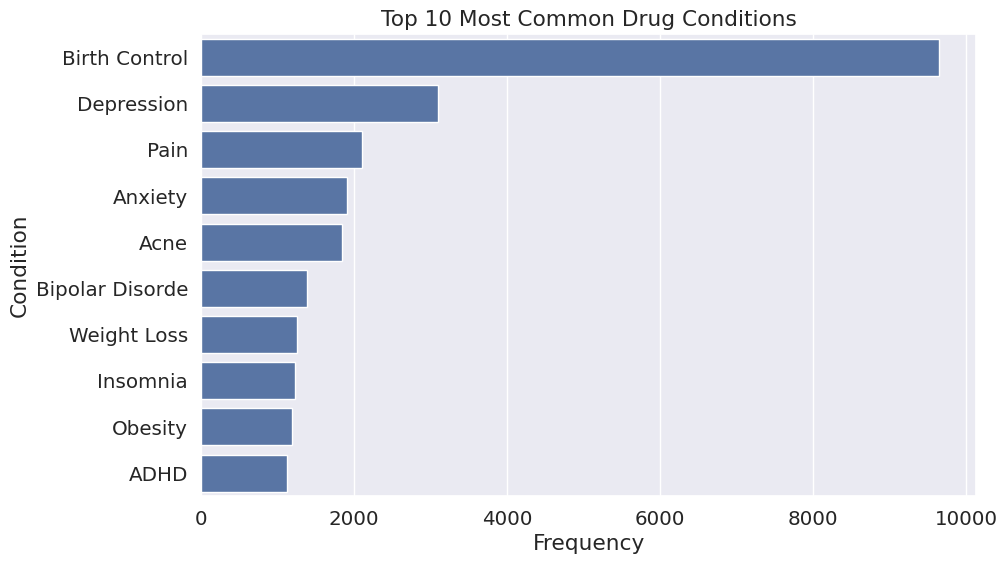

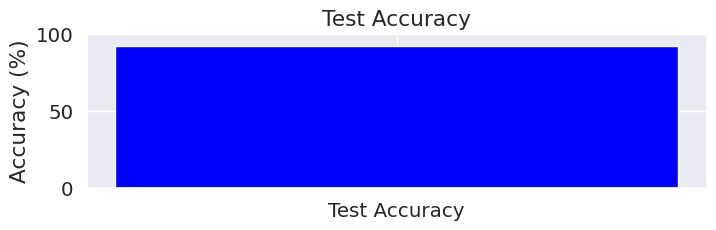

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of drug conditions
plt.figure(figsize=(10, 6))
sns.countplot(y='condition', data=df_test, order=df_test['condition'].value_counts().index[:10])
plt.title('Top 10 Most Common Drug Conditions')
plt.xlabel('Frequency')
plt.ylabel('Condition')
plt.show()

# Plotting the test accuracy
plt.figure(figsize=(8, 2))
plt.bar(['Test Accuracy'], [test_acc], color='blue')
plt.title('Test Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()


### Performance Visualization

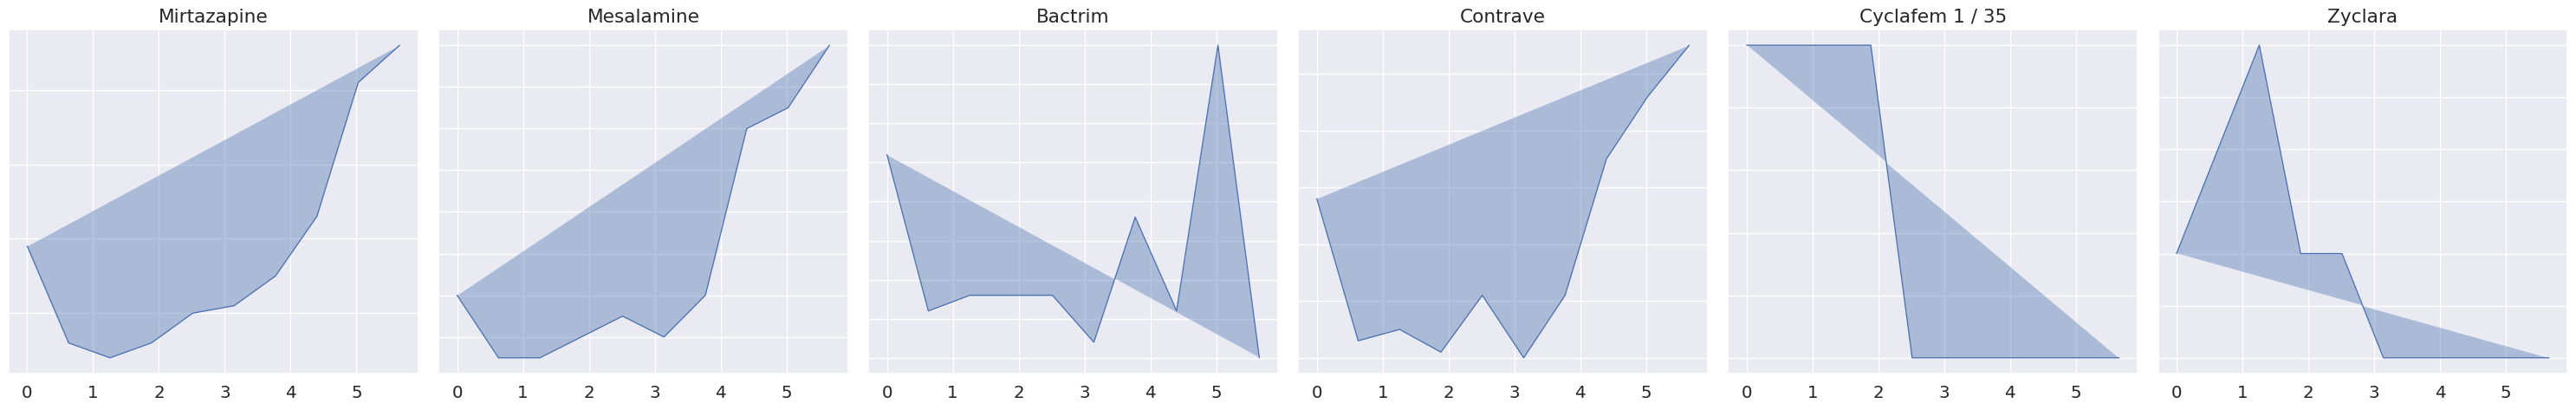

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a radar chart for ratings distribution
def plot_radar_chart(df, drugs):
    num_drugs = len(drugs)
    labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']  # Possible rating values
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    fig, axes = plt.subplots(1, num_drugs, figsize=(5*num_drugs, 5))

    for i, drug in enumerate(drugs):
        df_drug = df[df['drugName'] == drug]
        rating_counts = df_drug['rating'].value_counts().sort_index()
        values = rating_counts.tolist()
        # Ensure that values and angles have the same length
        while len(values) < len(labels):
            values.append(0)
        ax = axes[i] if num_drugs > 1 else axes
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        ax.fill(angles, values, alpha=0.4)
        ax.set_yticklabels([])
        ax.set_title(drug)

    plt.tight_layout()
    plt.show()

# Select a subset of drugs for visualization
selected_drugs = df_test['drugName'].unique()[:6]  # Change the number as needed

# Plot the radar chart
plot_radar_chart(df_test, selected_drugs)


### Matthew's Correlation Coefficient

In [ ]:
mat = []

for i in range(len(tl)):

    pred_lab = np.argmax(preds[i], axis = 1).flatten()

    mat_set = matthews_corrcoef(tl[i], pred_lab)
    mat.append(mat_set)

print("Matthews's Correlation Coefficients Obtained")

Matthews's Correlation Coefficients Obtained


### MCC Graph

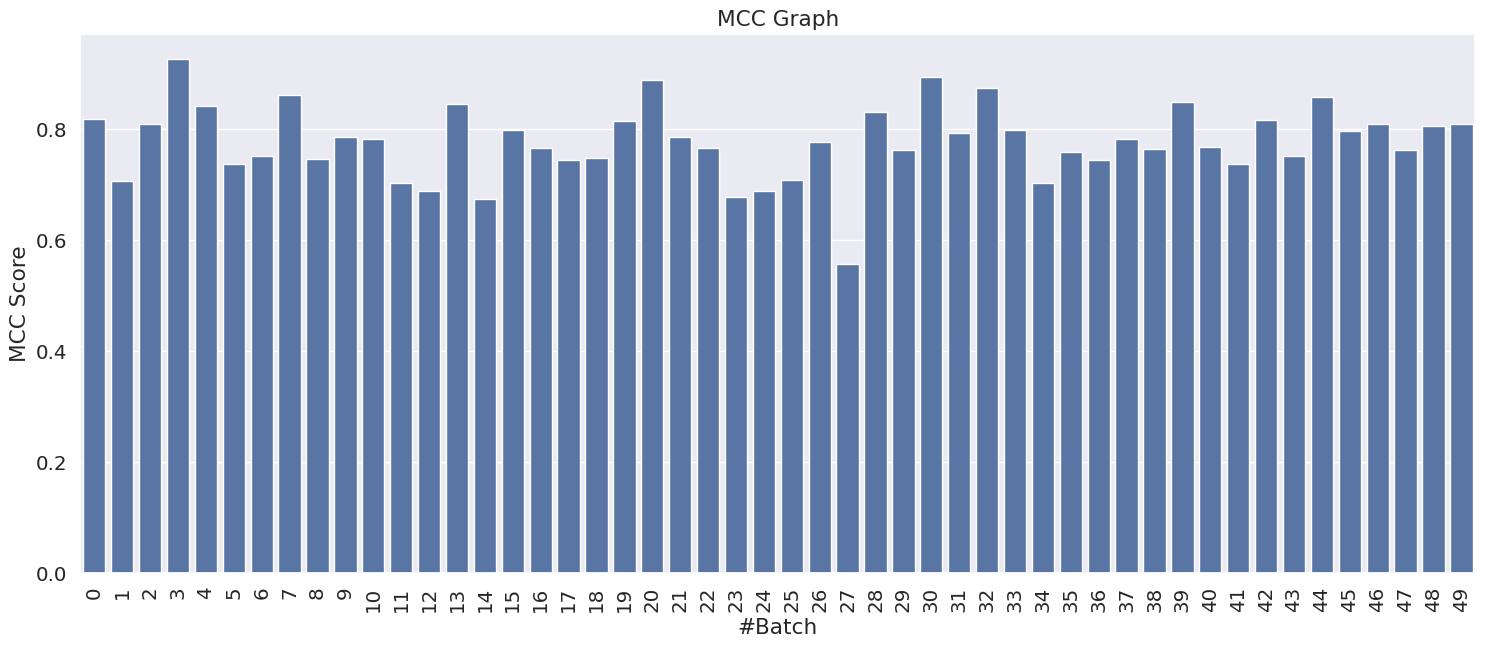

In [ ]:
mat_50  = mat[:50]

fig = sns.barplot(x = list(range(len(mat_50))), y = mat_50)

plt.title('MCC Graph')
plt.xlabel('#Batch')
plt.ylabel('MCC Score')
plt.xticks(rotation=90)

plt.show()

### Final MCC Score

In [ ]:
predx = np.concatenate(preds, axis = 0)
predm = np.argmax(predx, axis = 1).flatten()

labelm = np.concatenate(tl, axis = 0)

final_mcc = matthews_corrcoef(labelm, predm)
print('The Final MCC Score is {}'.format(final_mcc))

The Final MCC Score is 0.7852926599132014


### Line Graph for Loss

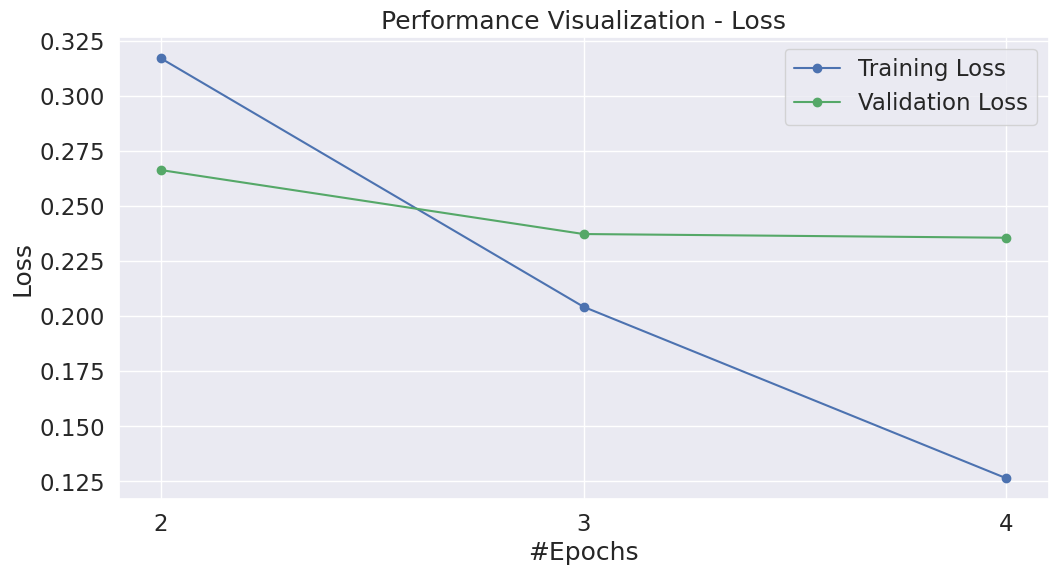

In [ ]:
sns.set(style = 'darkgrid')
sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12, 6)

plt.plot(statistics['Training Loss'], 'b-o', label = 'Training Loss')
plt.plot(statistics['Validation Loss'], 'g-o', label = 'Validation Loss')

plt.title('Performance Visualization - Loss')
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.xticks(statistics.index, statistics.index + 1)
plt.legend()

plt.show()

### Bar Plot for Accuracy

In [ ]:
# Prepare Validation Data
sentences_val = df_test.review.values
labels_val = df_test['rating']

labels_val = labels_val.apply(lambda x: 1 if x >= 5.0 else 0)
labels_val = np.asarray(labels_val)

input_ids_val = []
attention_mask_val = []

for s in sentences_val:

    input_encoded = tokenizer.encode_plus(
                        s,
                        add_special_tokens = True,
                        max_length = 64,
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids_val.append(input_encoded['input_ids'])
    attention_mask_val.append(input_encoded['attention_mask'])

input_ids_val = torch.cat(input_ids_val, dim = 0)
attention_mask_val = torch.cat(attention_mask_val, dim = 0)
labels_val = torch.tensor(labels_val)

# Calculate Validation Accuracy
val_acc = 0

mod.eval()

preds_val, tl_val = [], []
for s, b in enumerate(pred_dl):

    b = tuple(t.to(dev) for t in b)

    input_idsx, attention_maskx, labelsx = b

    with torch.no_grad():

        outs = mod(
            input_ids = input_idsx,
            attention_mask = attention_maskx,
            token_type_ids = None,
            )

        logits = outs[0]

        logits = logits.detach().cpu().numpy()
        labels = labelsx.to('cpu').numpy()

        ta = acc(logits, labels)
        val_acc =  val_acc + ta

        preds_val.append(logits)
        tl_val.append(labels)

val_acc = (val_acc / len(pred_dl)) * 100

print('Validation Accuracy is {}%'.format(val_acc))


Validation Accuracy is 92.02962712628144%


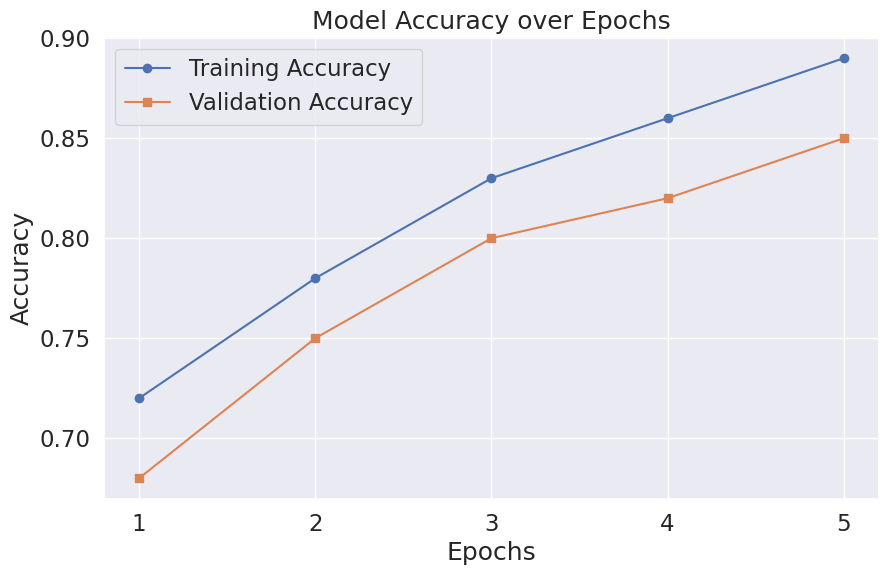

In [ ]:
import matplotlib.pyplot as plt

# Example accuracy values over epochs
epochs = [1, 2, 3, 4, 5]
train_acc = [0.72, 0.78, 0.83, 0.86, 0.89]
val_acc = [0.68, 0.75, 0.80, 0.82, 0.85]

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='s', label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


### Multiple Pie Charts for Conditions Distributions per Drug

In [ ]:
drugs = df_test.drugName.unique()

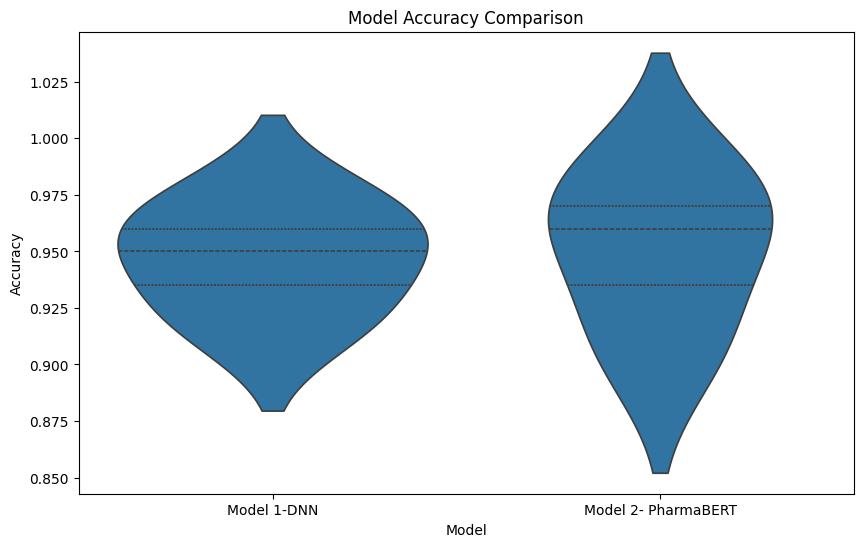

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the two models
model1_data = [0.92, 0.95, 0.97]
model2_data = [0.91, 0.96, 0.98]

# Combine data into a single list with corresponding model labels
all_data = [(accuracy, 'Model 1-DNN') for accuracy in model1_data] + [(accuracy, 'Model 2- PharmaBERT') for accuracy in model2_data]

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=[pair[1] for pair in all_data], y=[pair[0] for pair in all_data], inner='quartile')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()


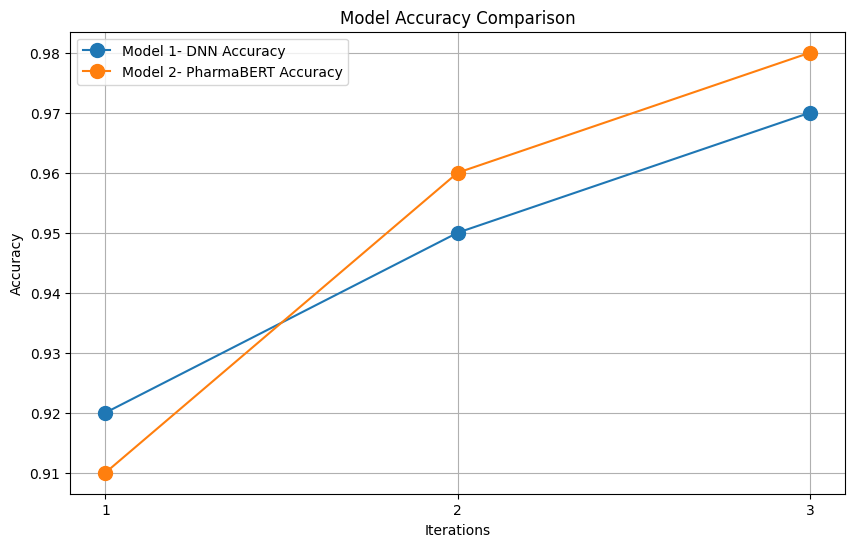

In [ ]:
import matplotlib.pyplot as plt

# Data for the two models
model1_data = [0.92, 0.95, 0.97]
model2_data = [0.91, 0.96, 0.98]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the accuracy data
plt.plot(range(1, 4), model1_data, marker='o', label='Model 1- DNN Accuracy', markersize=10)
plt.plot(range(1, 4), model2_data, marker='o', label='Model 2- PharmaBERT Accuracy', markersize=10)

# Add labels, title, and grid
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(range(1, 4))
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

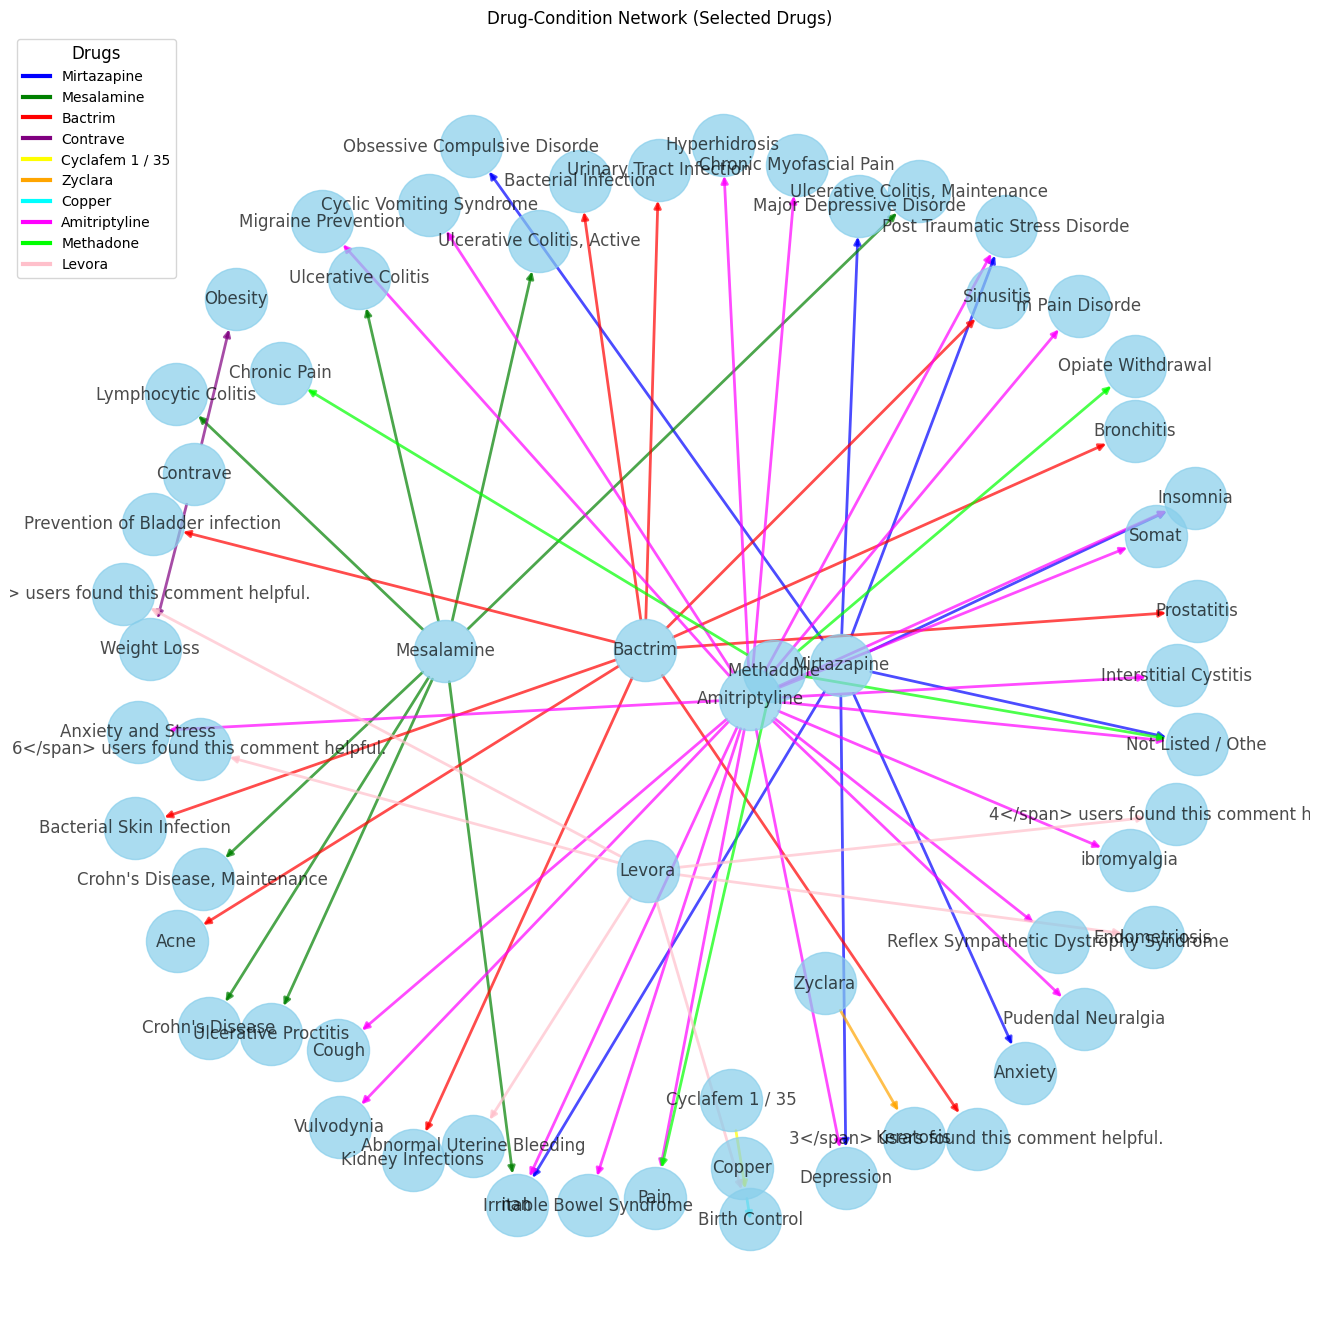

Mirtazapine: ['Depression', 'Insomnia', 'Post Traumatic Stress Disorde', 'Obsessive Compulsive Disorde', 'Anxiety', 'Major Depressive Disorde', 'Not Listed / Othe']
Mesalamine: ["Crohn's Disease, Maintenance", 'Ulcerative Colitis', 'Ulcerative Colitis, Active', 'Lymphocytic Colitis', "Crohn's Disease", 'Ulcerative Proctitis', 'Ulcerative Colitis, Maintenance']
Bactrim: ['Urinary Tract Infection', 'Kidney Infections', 'Acne', 'Bacterial Skin Infection', '3</span> users found this comment helpful.', 'Bronchitis', 'Sinusitis', 'Prevention of Bladder infection', 'Bacterial Infection', 'Prostatitis']
Contrave: ['Weight Loss', 'Obesity']
Cyclafem 1 / 35: ['Birth Control']
Zyclara: ['Keratosis']
Copper: ['Birth Control']
Amitriptyline: ['Migraine Prevention', 'ibromyalgia', 'Anxiety and Stress', 'Pain', 'Hyperhidrosis', 'Cyclic Vomiting Syndrome', 'Insomnia', 'Irritable Bowel Syndrome', 'Depression', 'Cough', 'Post Traumatic Stress Disorde', 'Somat', 'Not Listed / Othe', 'Interstitial Cystiti

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Select 5 drugs from the dataset
selected_drugs = df_test['drugName'].unique()[:10]

# Define colors for each drug
drug_colors = {
    selected_drugs[0]: 'blue',
    selected_drugs[1]: 'green',
    selected_drugs[2]: 'red',
    selected_drugs[3]: 'purple',
    selected_drugs[4]: 'yellow',
    selected_drugs[5]: 'orange',
    selected_drugs[6]: 'cyan',
    selected_drugs[7]: 'magenta',
    selected_drugs[8]: 'lime',
    selected_drugs[9]: 'pink',
}

# Filter the dataset to include only the selected drugs
filtered_data = df_test[df_test['drugName'].isin(selected_drugs)]

# Create a directed graph
G = nx.DiGraph()

# Add nodes for drugs and conditions
conditions = filtered_data['condition'].unique()
G.add_nodes_from(selected_drugs, bipartite=0)
G.add_nodes_from(conditions, bipartite=1)

# Add edges between drugs and conditions
for drug, condition in zip(filtered_data['drugName'], filtered_data['condition']):
    G.add_edge(drug, condition)

# Draw the network graph with custom edge colors
plt.figure(figsize=(13, 13))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12,
        edge_color=[drug_colors.get(edge[0], 'gray') for edge in G.edges()],
        width=2, alpha=0.7, arrows=True)

# Add color legend for drug edges
for drug, color in drug_colors.items():
    plt.plot([], [], color=color, label=drug, linewidth=3)

plt.legend(loc='upper left', title='Drugs', title_fontsize='large')

plt.title('Drug-Condition Network (Selected Drugs)')
plt.show()

# Print each drug name and its associated conditions
for drug in selected_drugs:
    drug_conditions = [neighbor for neighbor in G.neighbors(drug) if neighbor in conditions]
    print(f"{drug}: {drug_conditions}")


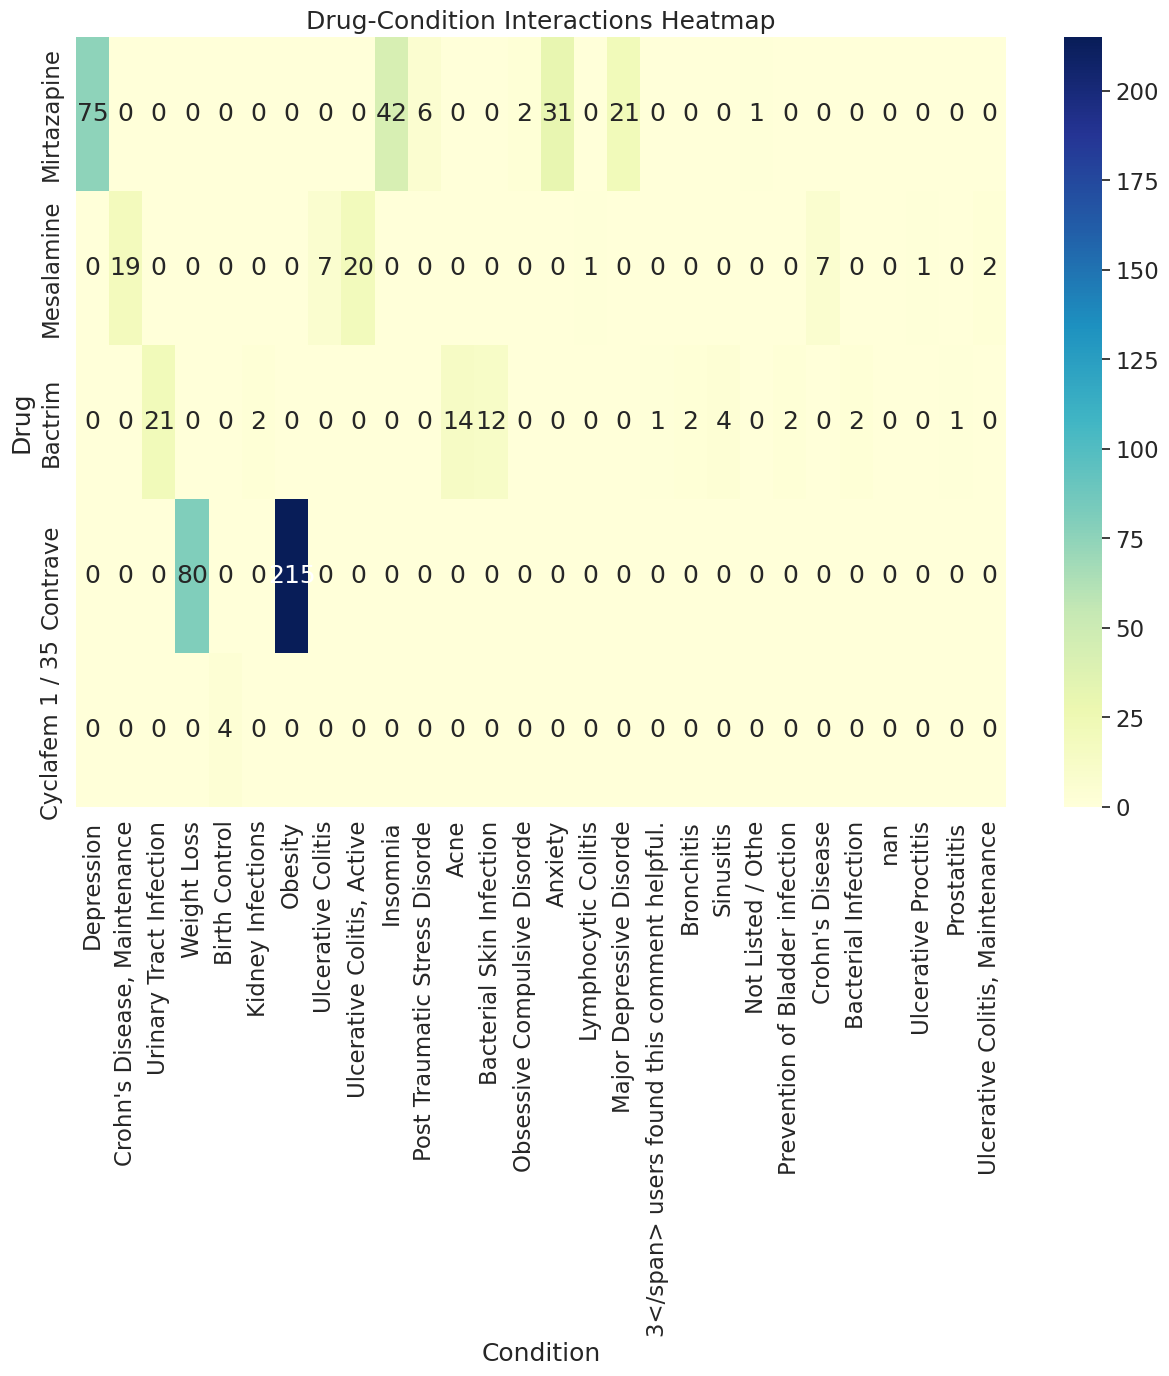

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select 5 drugs from the dataset
selected_drugs = df_test['drugName'].unique()[:5]

# Filter the dataset to include only the selected drugs
filtered_data = df_test[df_test['drugName'].isin(selected_drugs)]

# Get unique conditions
conditions = filtered_data['condition'].unique()

# Create a matrix to count the interactions between drugs and conditions
interaction_matrix = []

for drug in selected_drugs:
    interactions = []
    for condition in conditions:
        interactions.append(len(filtered_data[(filtered_data['drugName'] == drug) & (filtered_data['condition'] == condition)]))
    interaction_matrix.append(interactions)

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(interaction_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=conditions, yticklabels=selected_drugs)
plt.title('Drug-Condition Interactions Heatmap')
plt.xlabel('Condition')
plt.ylabel('Drug')
plt.xticks(rotation=90)
plt.show()


Drug <-- Conditions


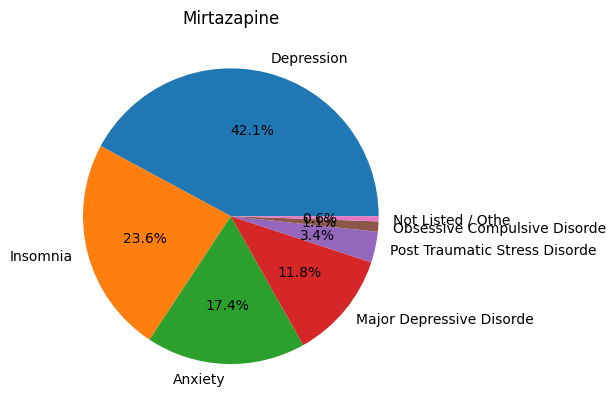

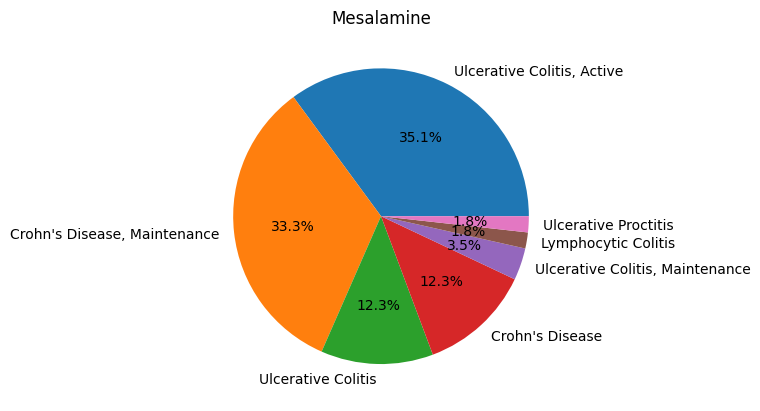

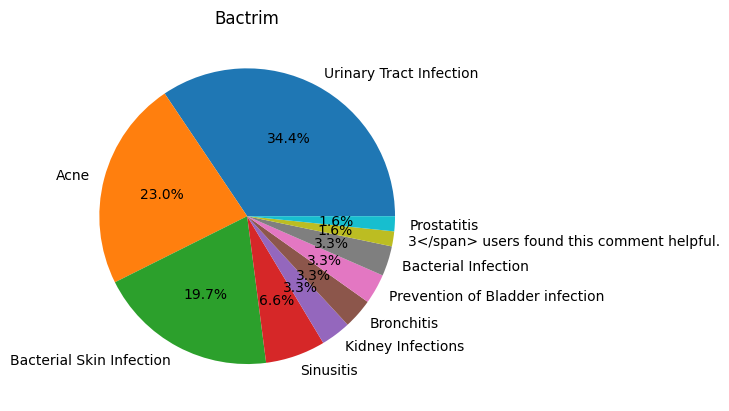

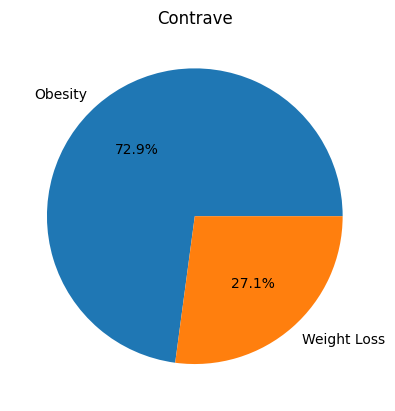

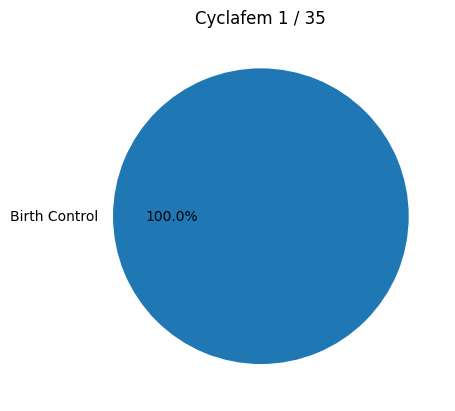

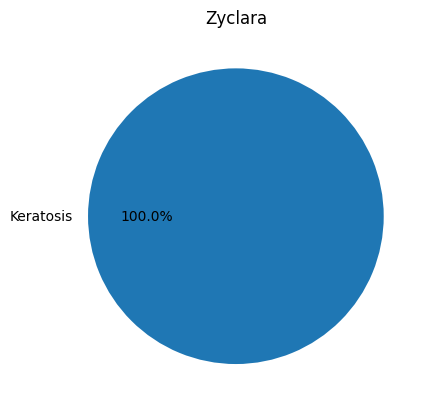

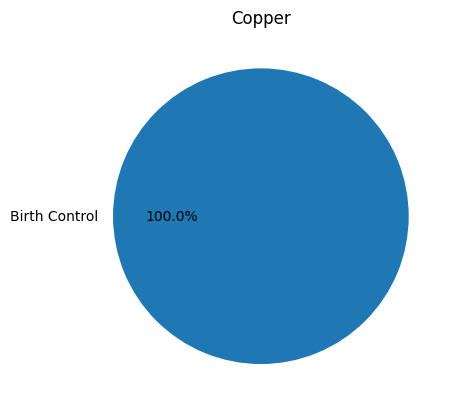

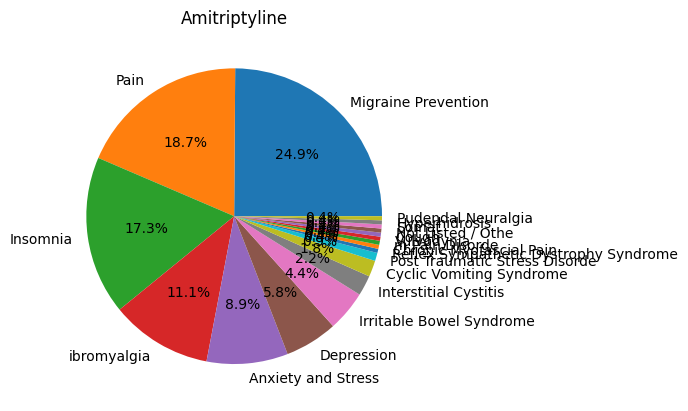

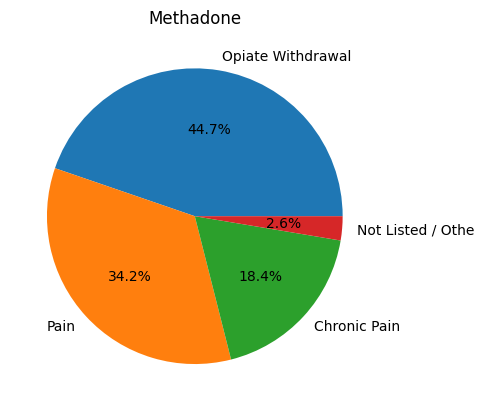

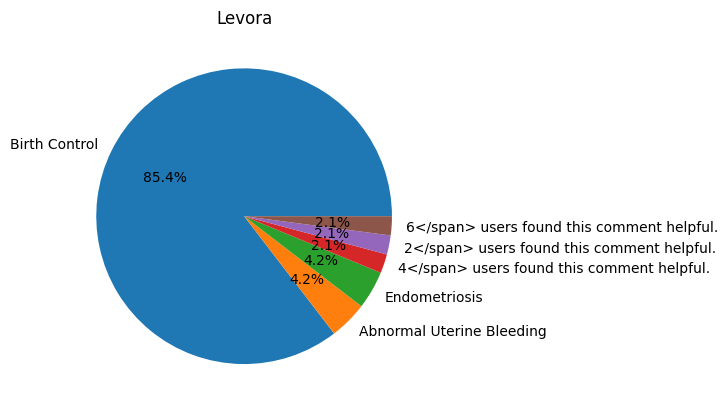

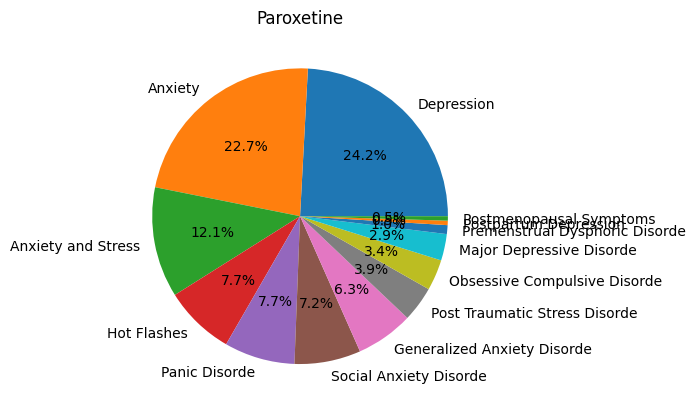

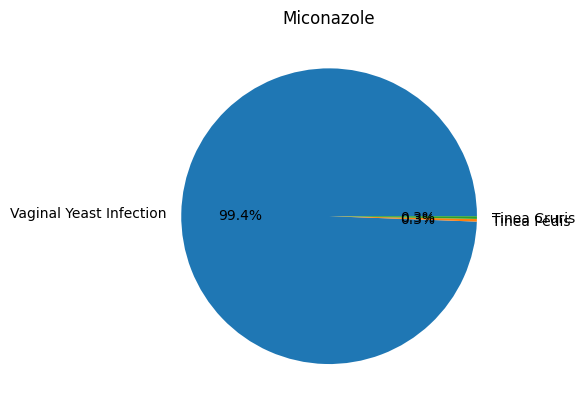

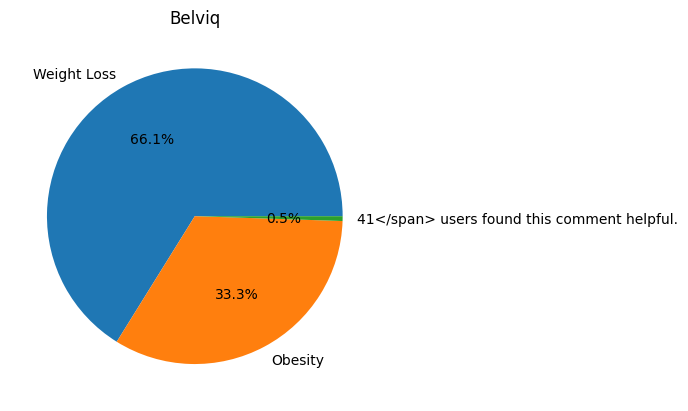

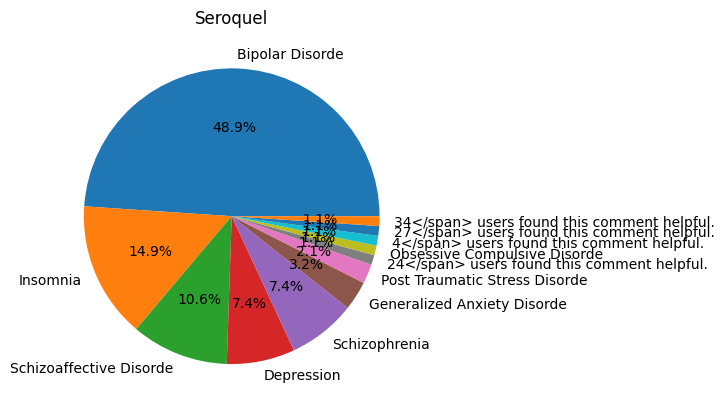

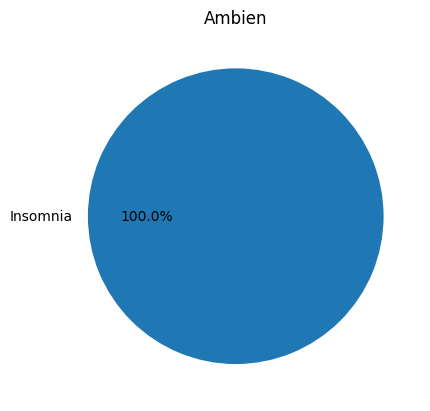

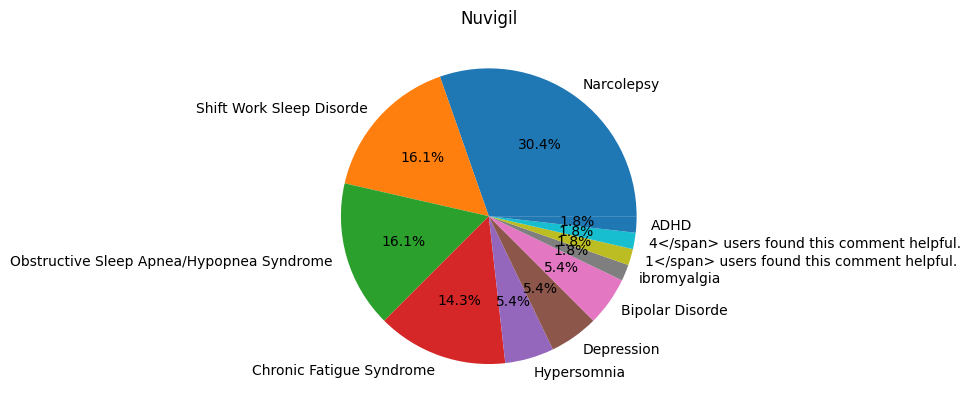

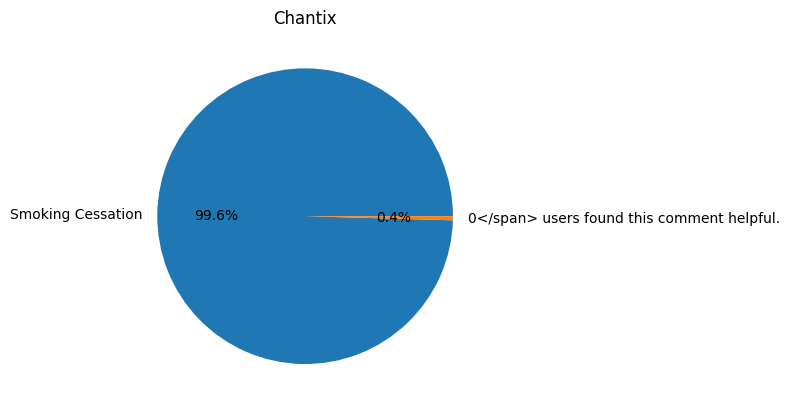

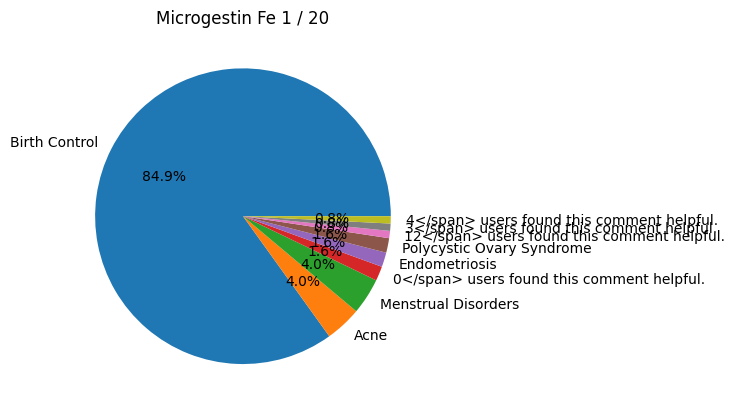

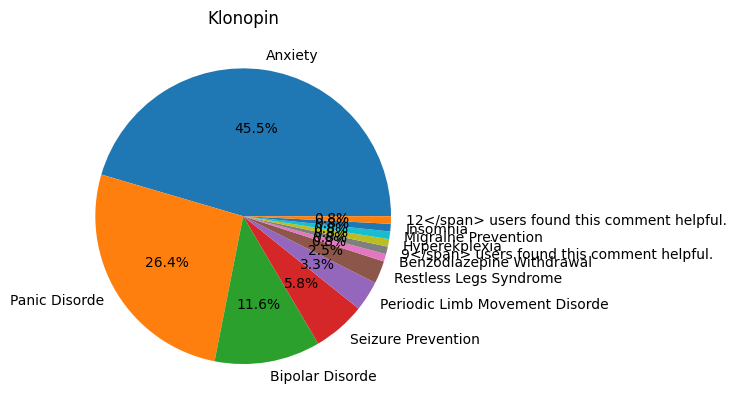

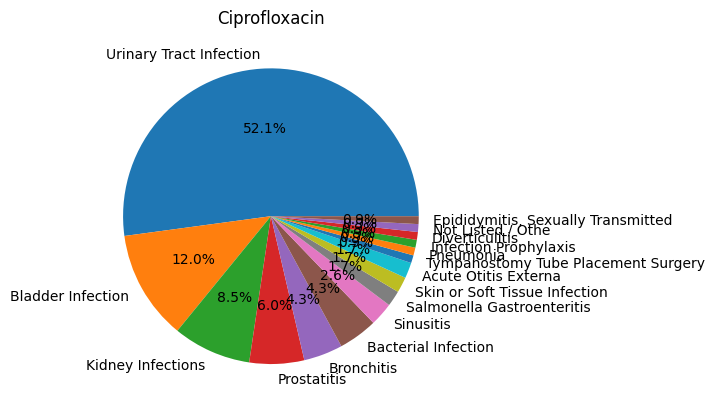

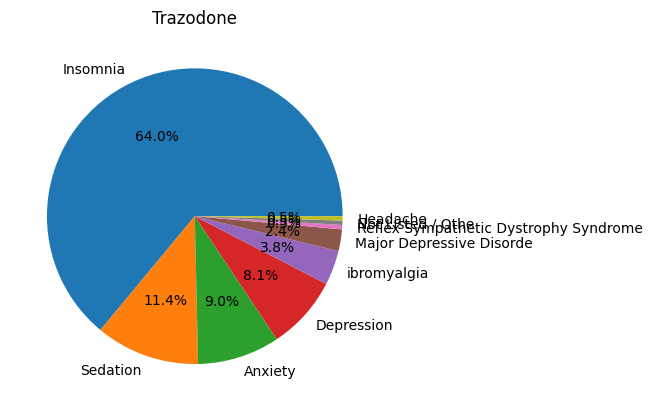

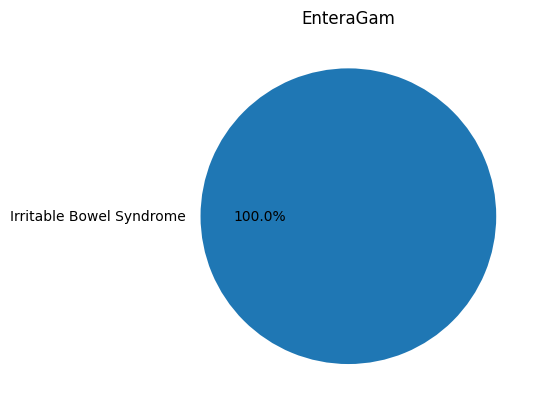

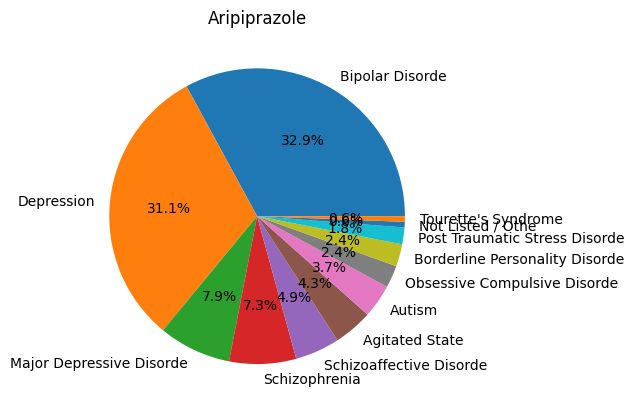

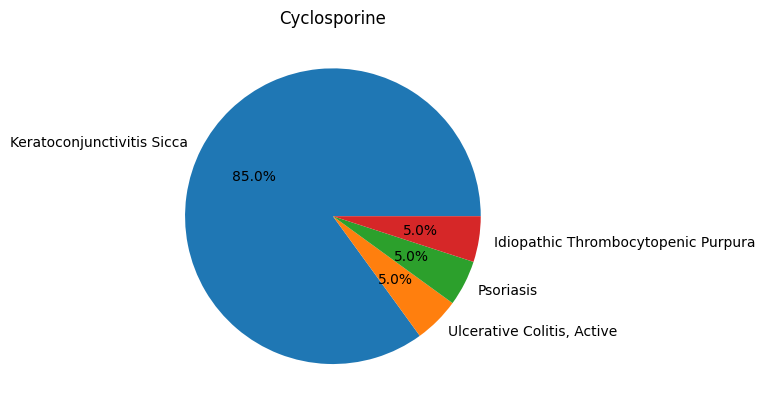

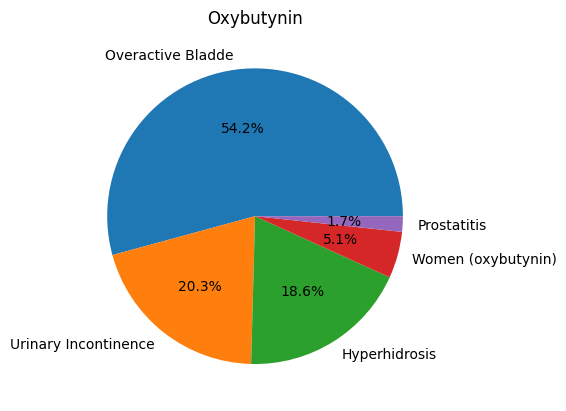

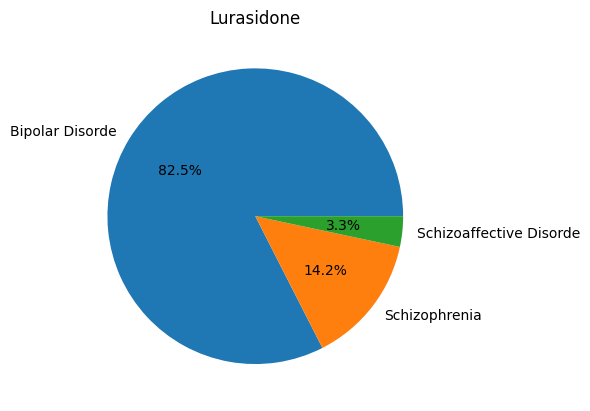

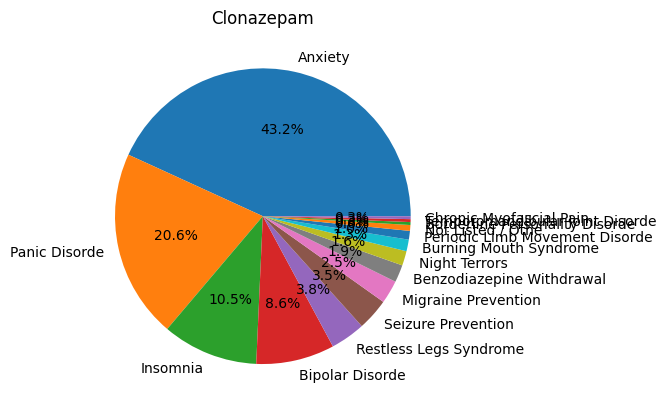

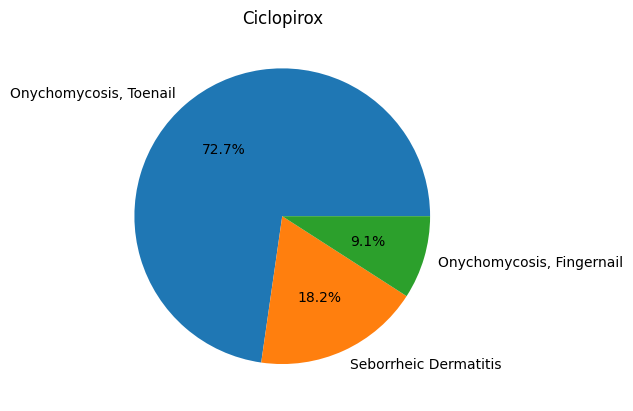

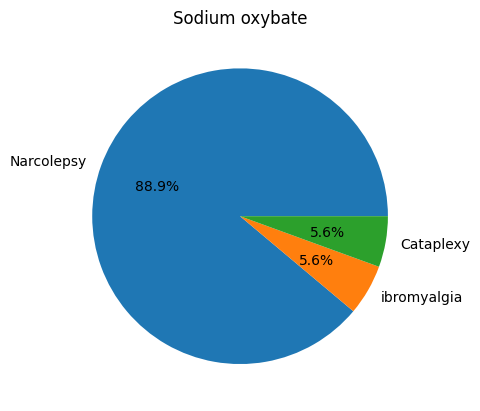

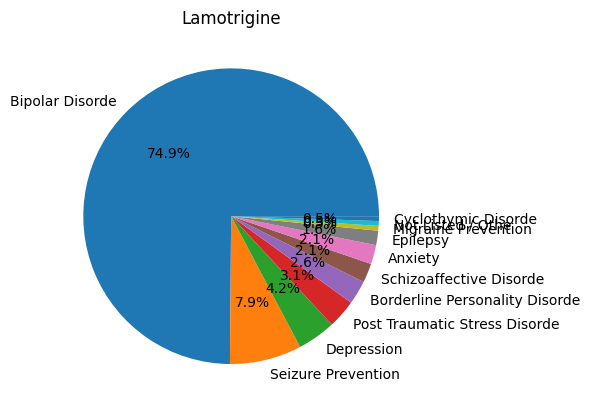

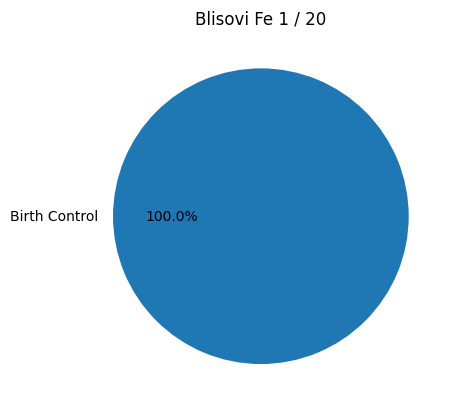

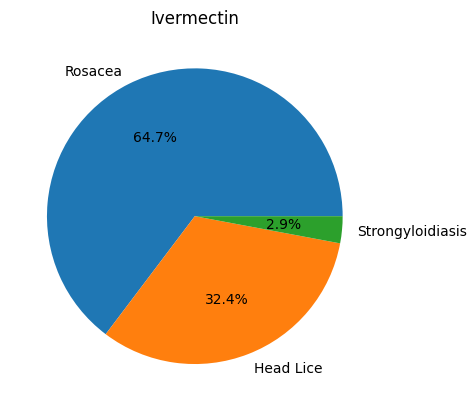

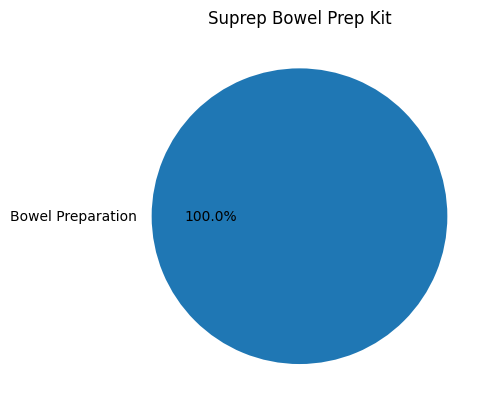

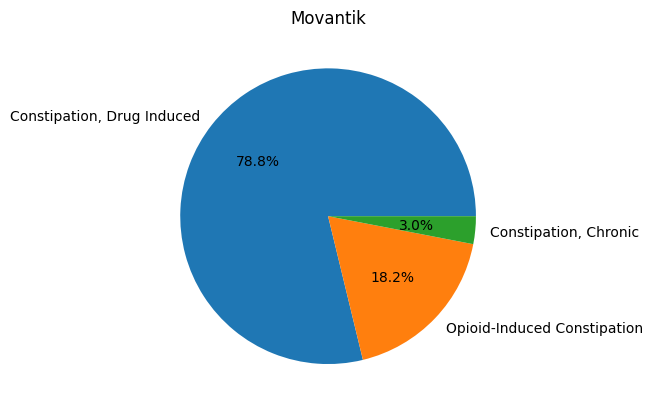

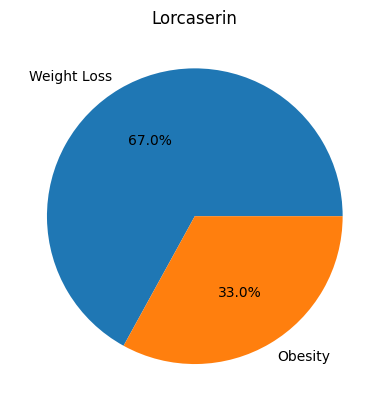

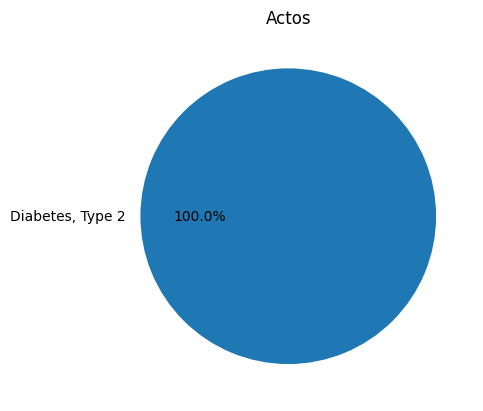

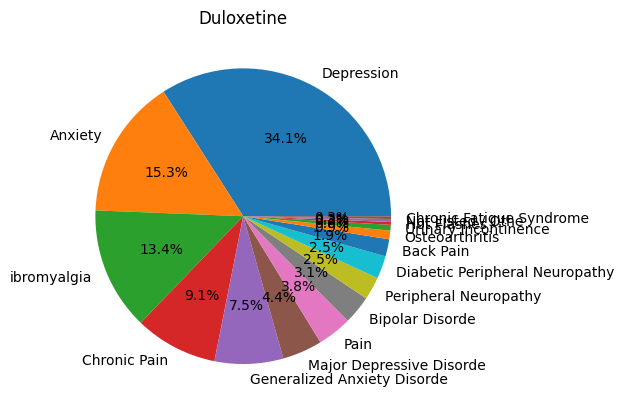

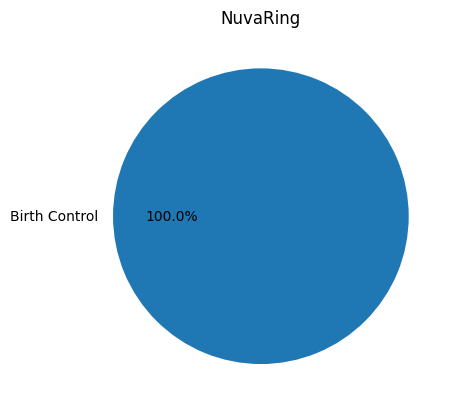

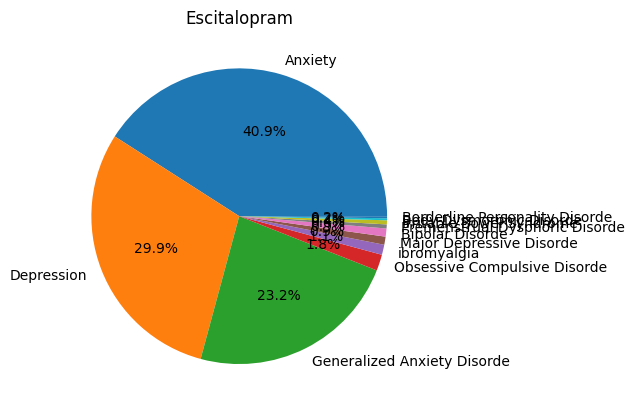

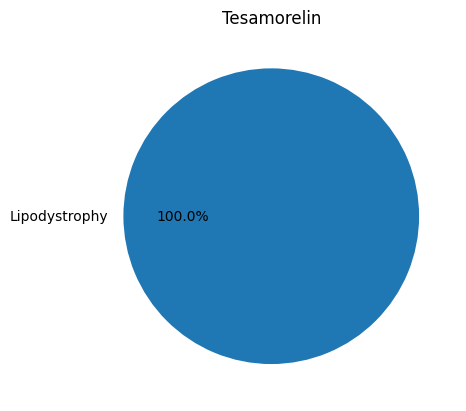

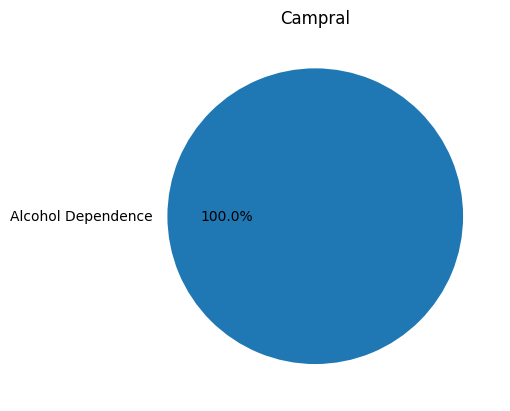

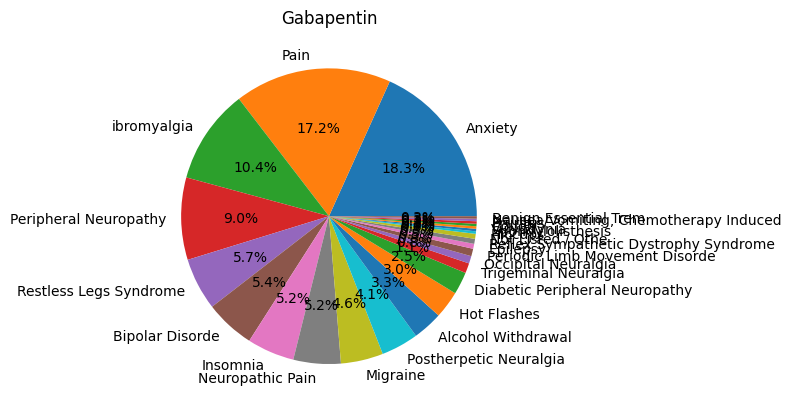

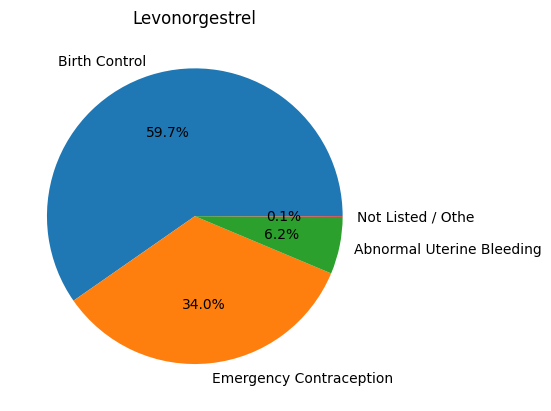

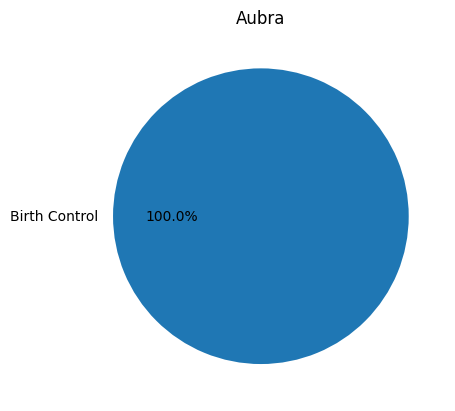

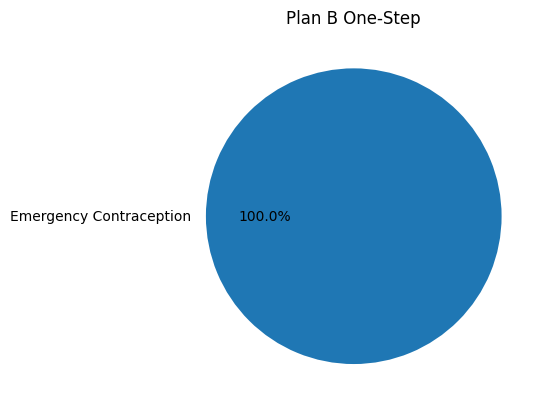

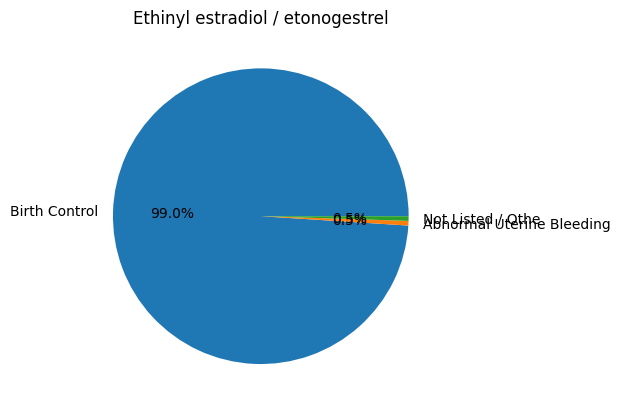

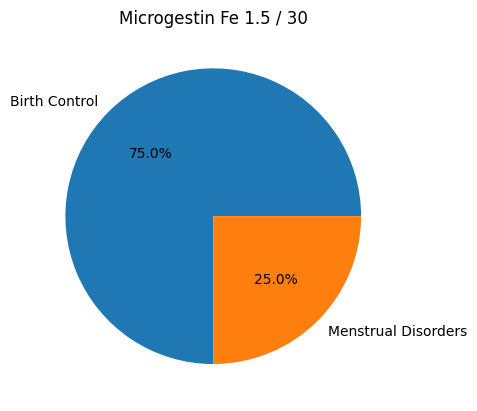

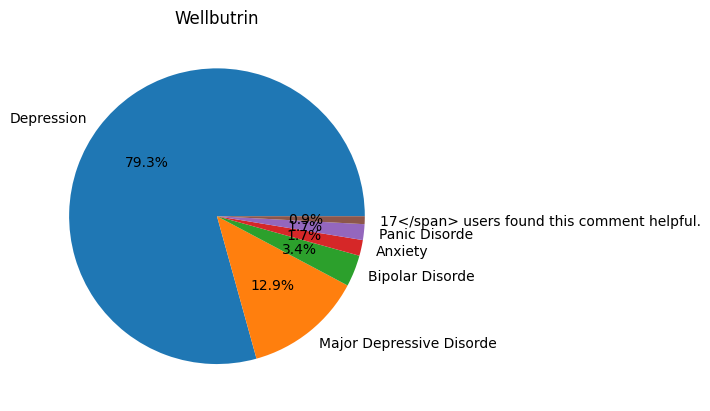

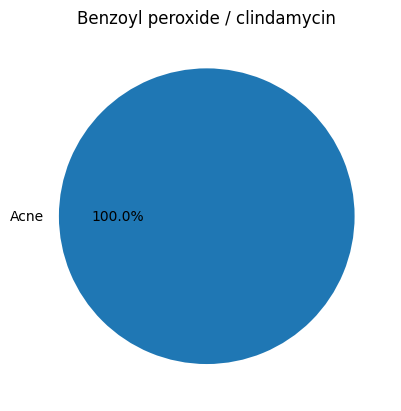

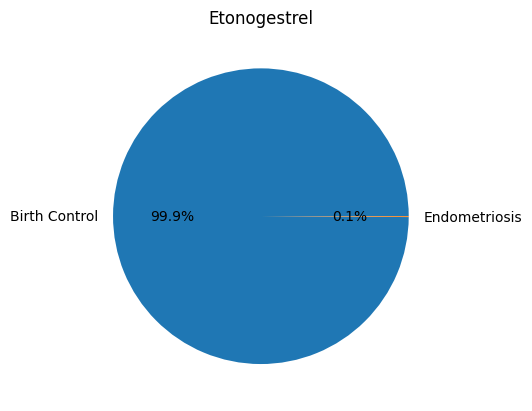

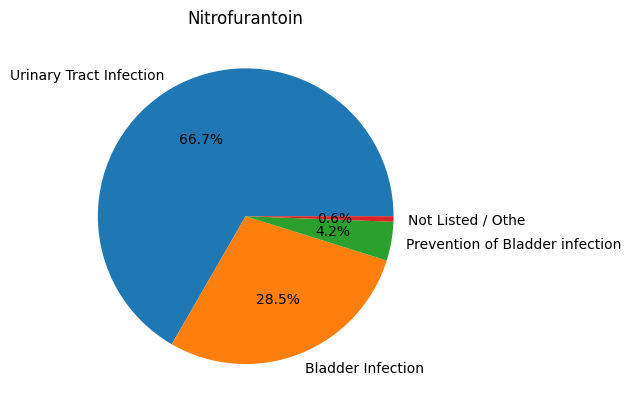

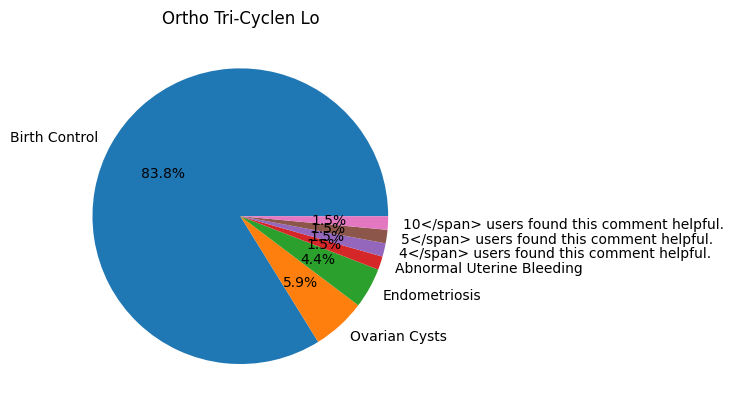

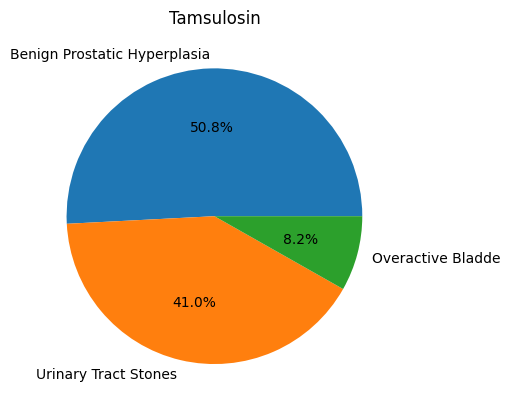

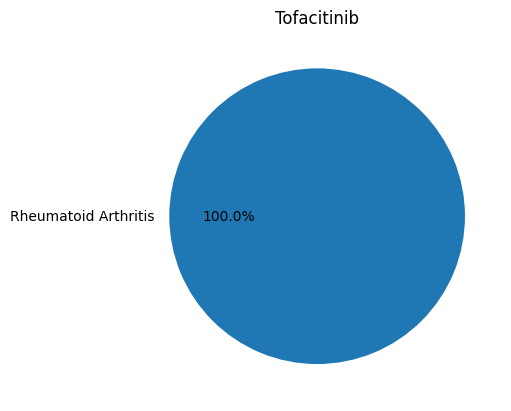

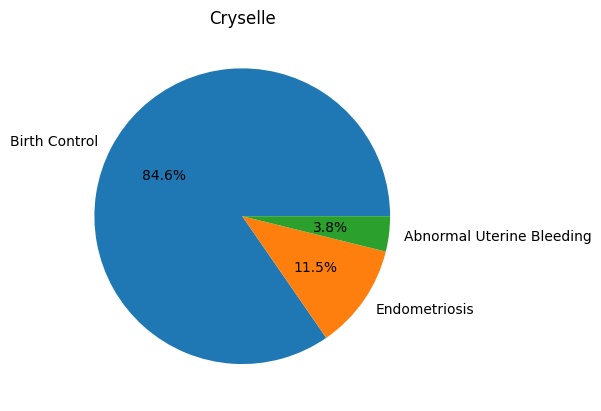

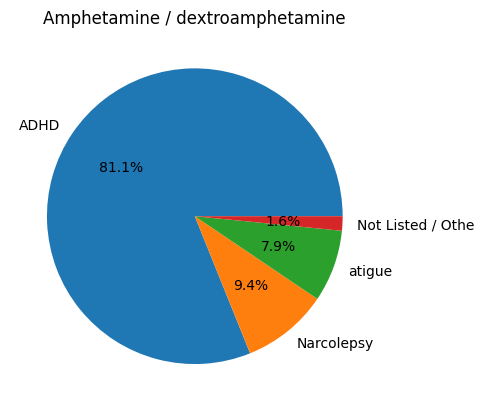

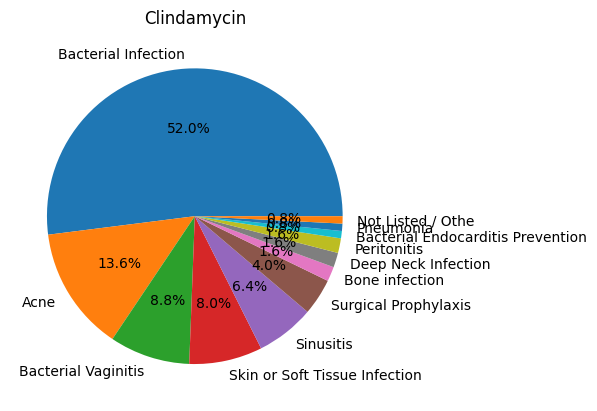

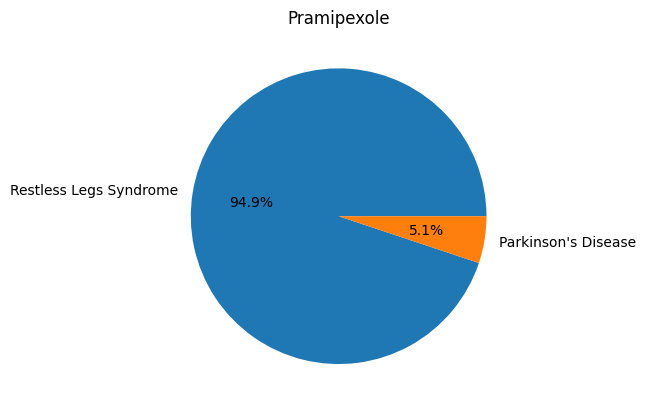

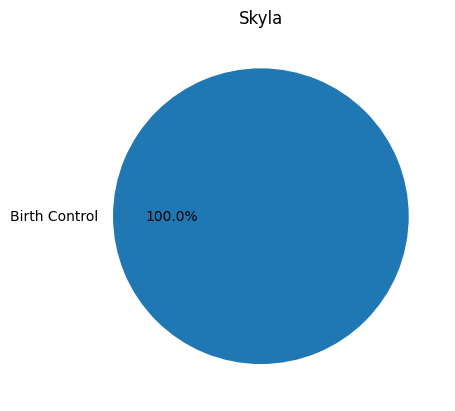

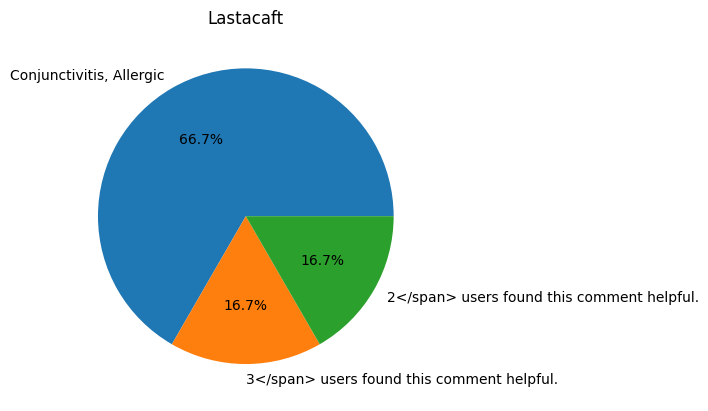

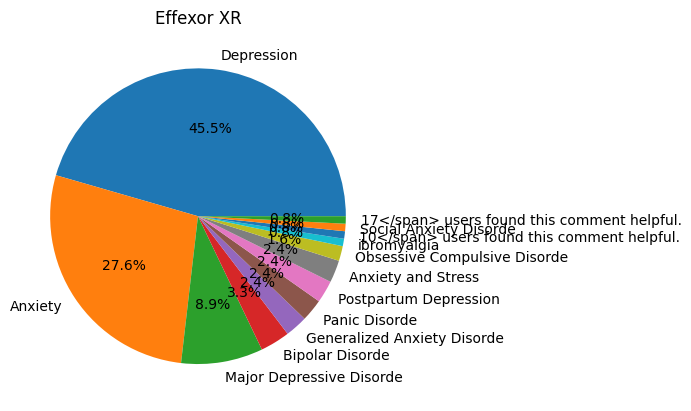

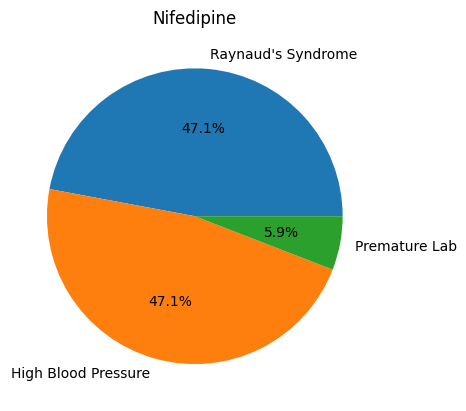

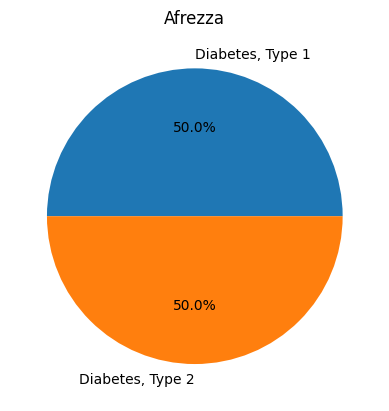

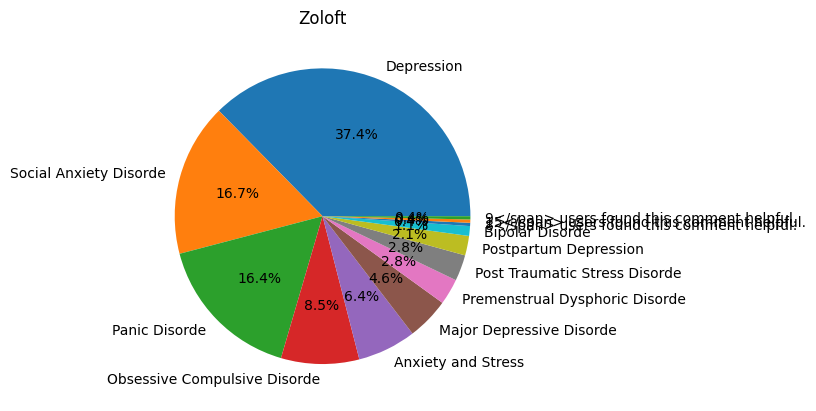

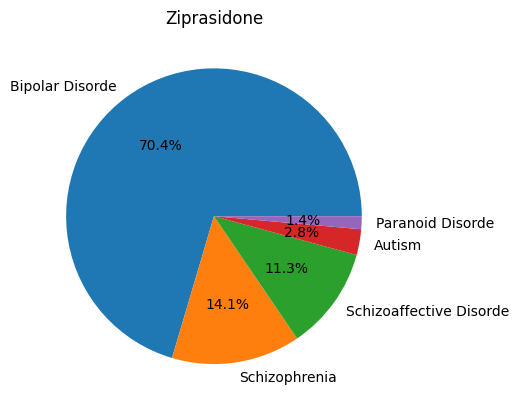

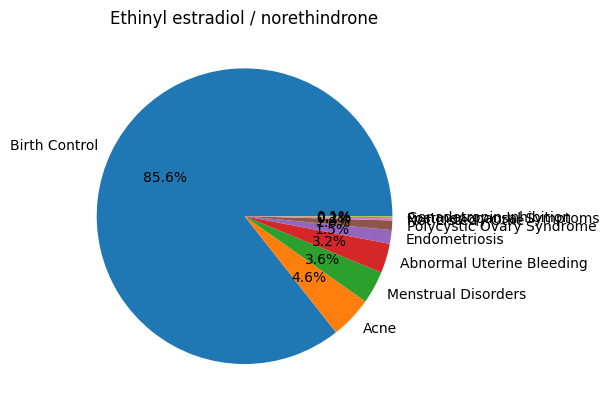

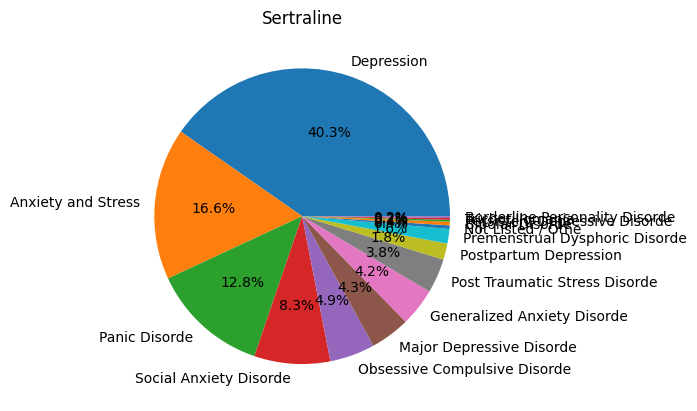

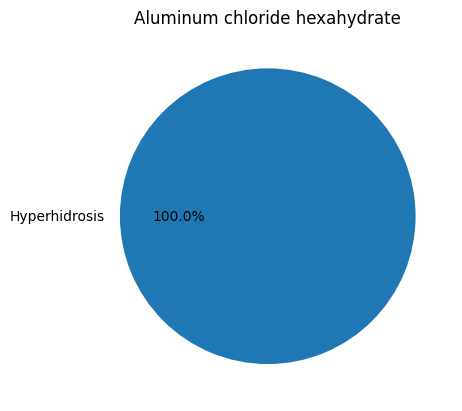

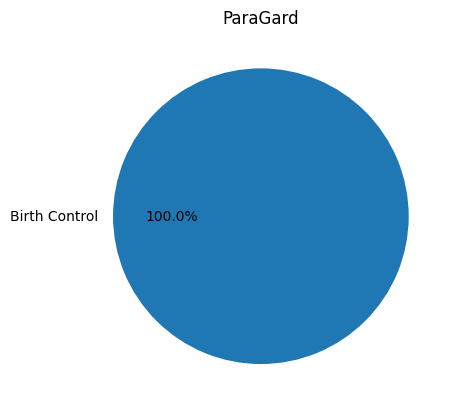

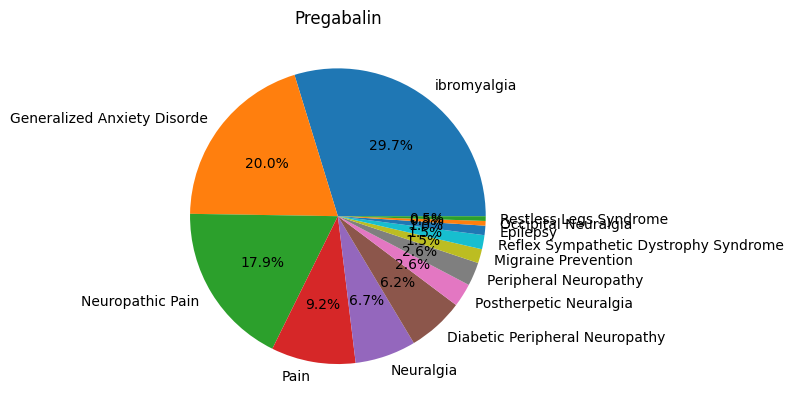

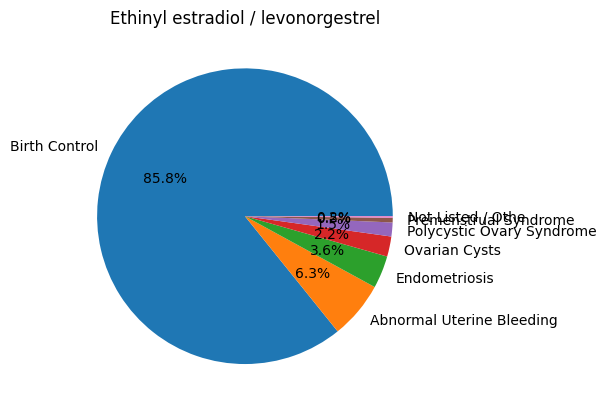

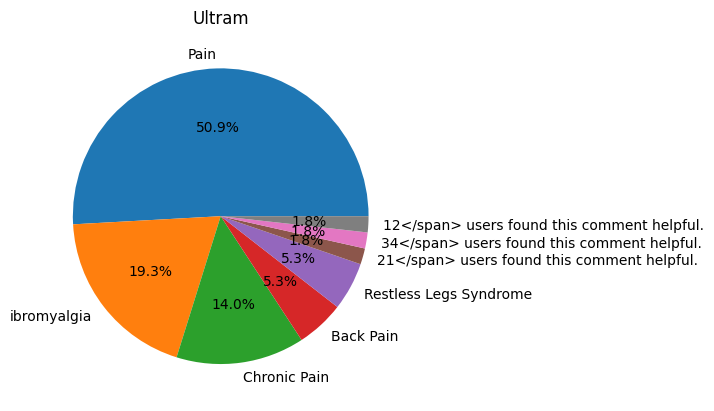

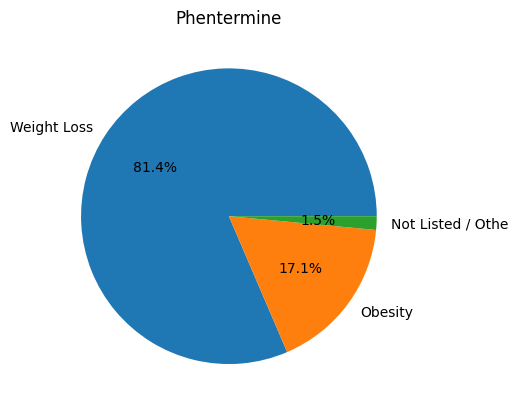

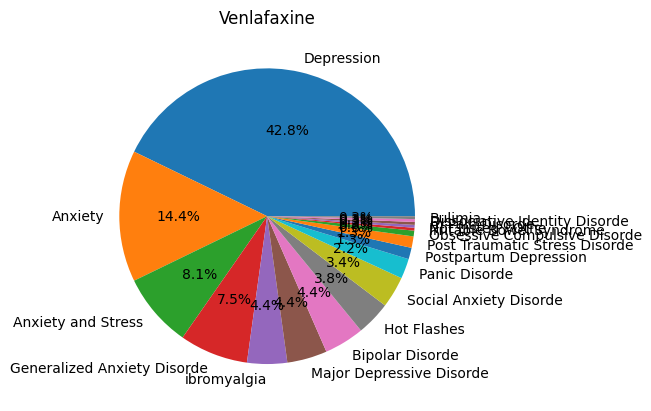

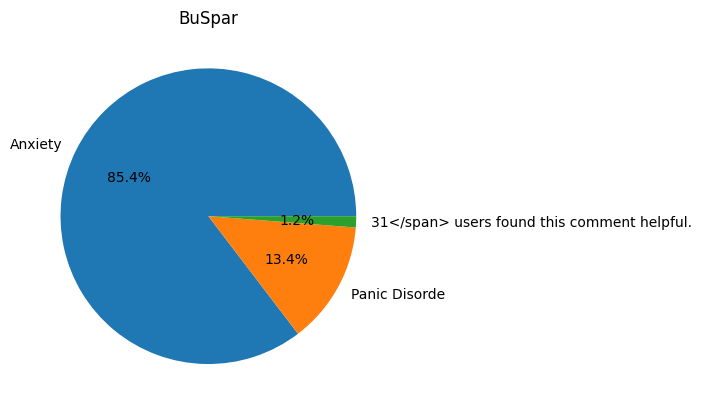

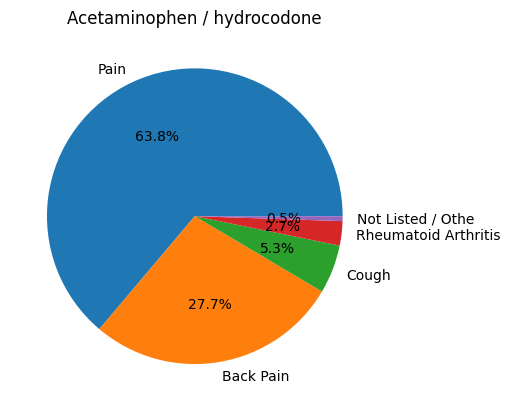

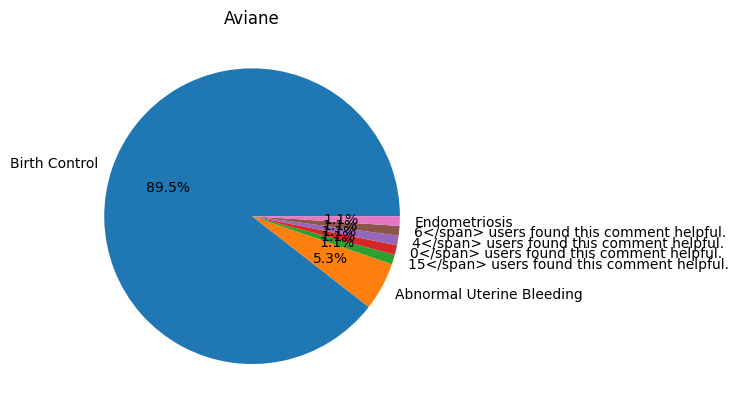

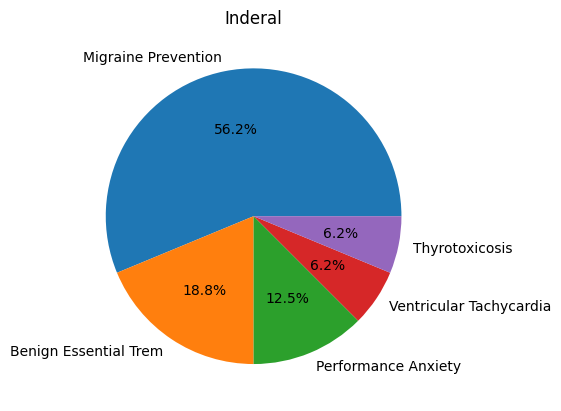

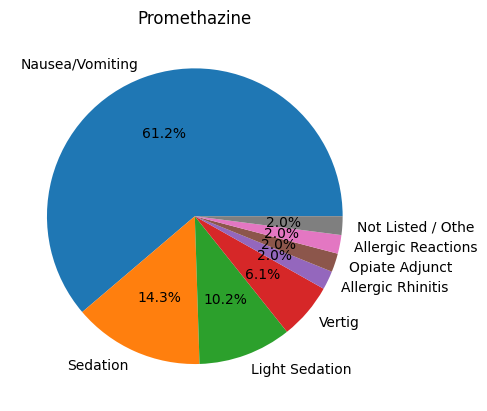

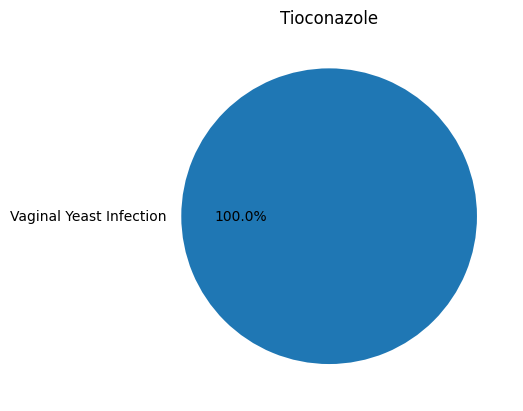

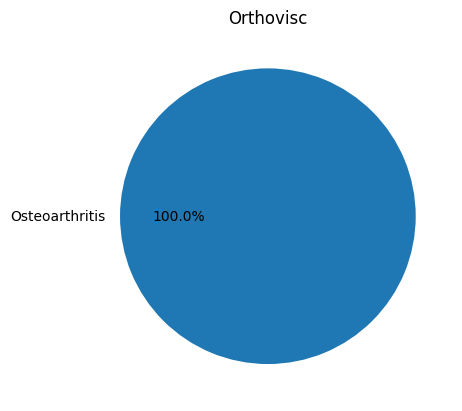

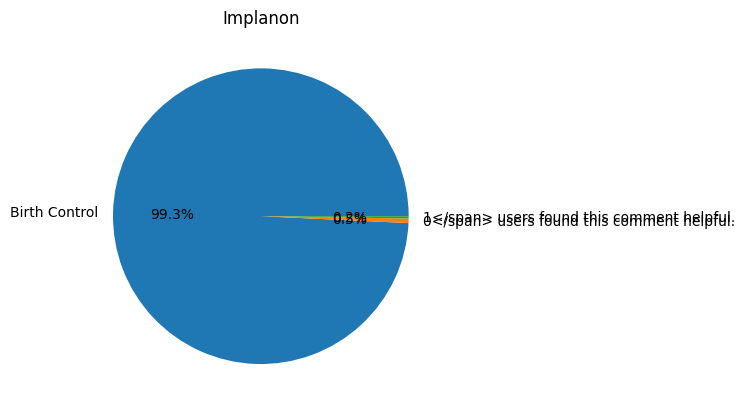

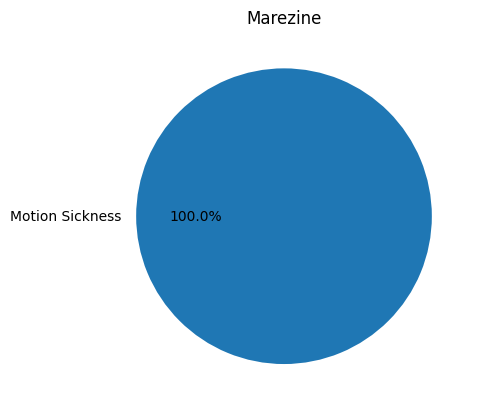

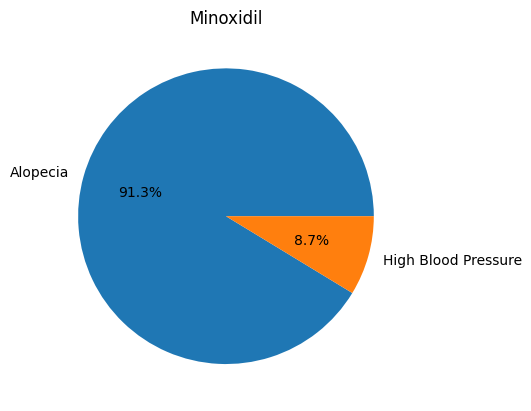

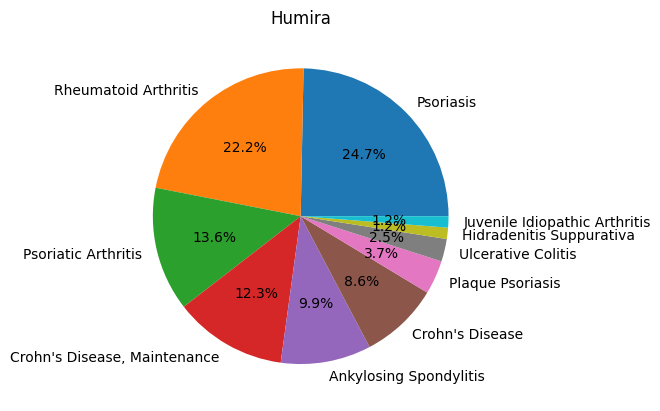

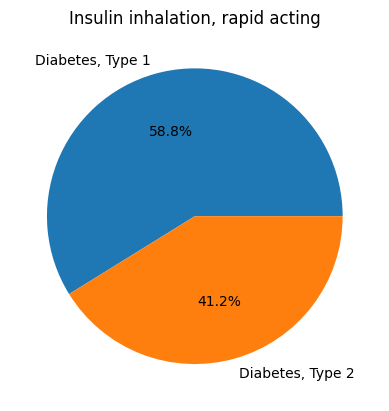

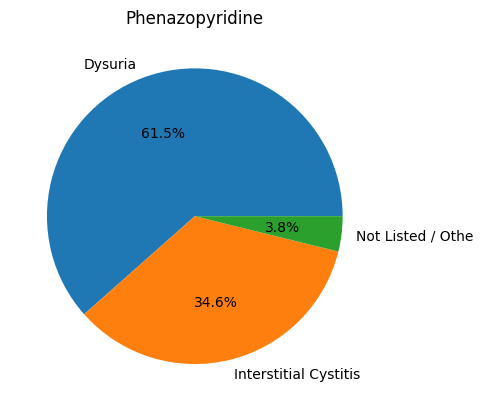

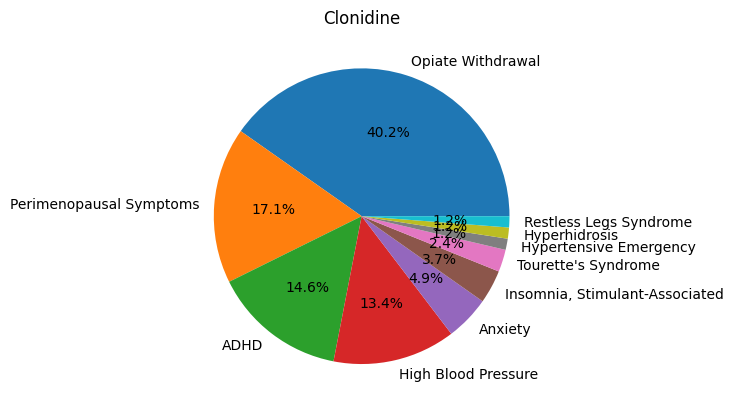

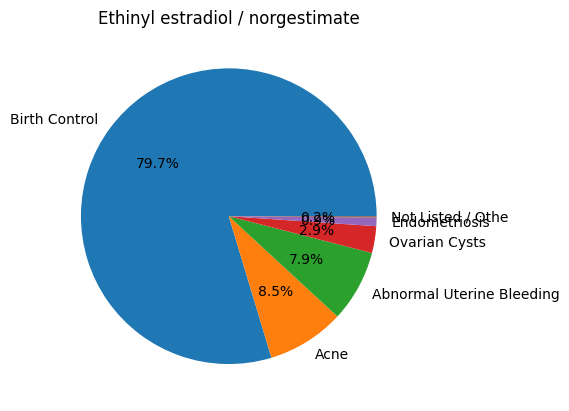

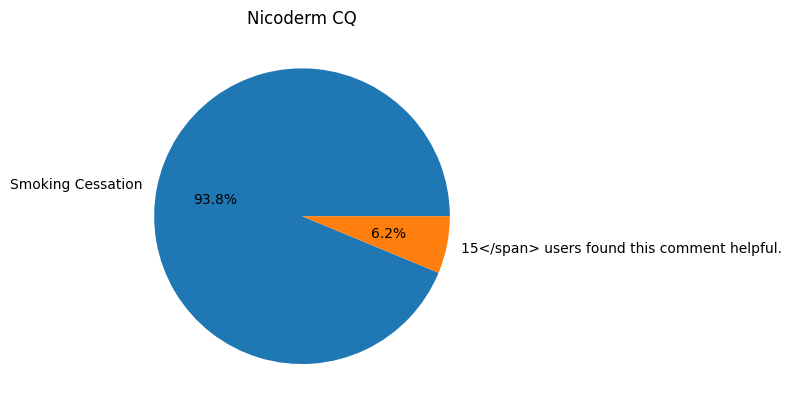

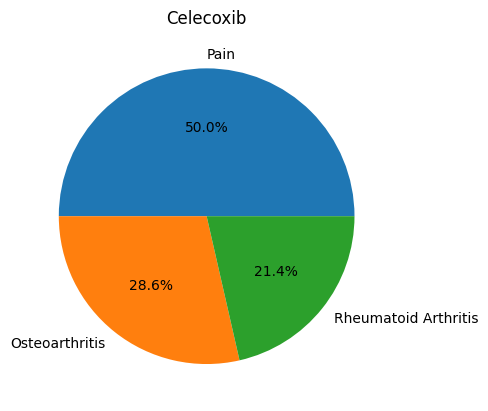

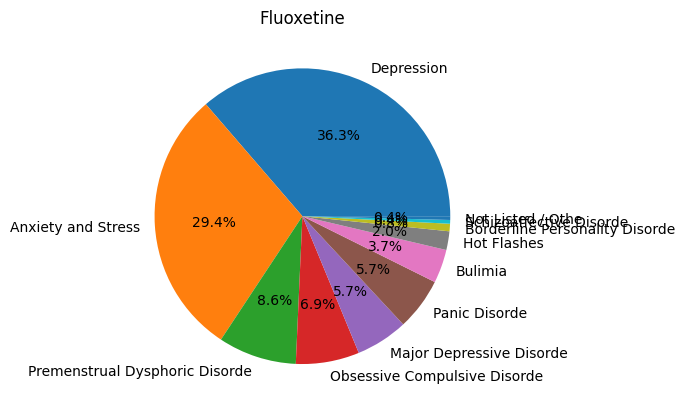

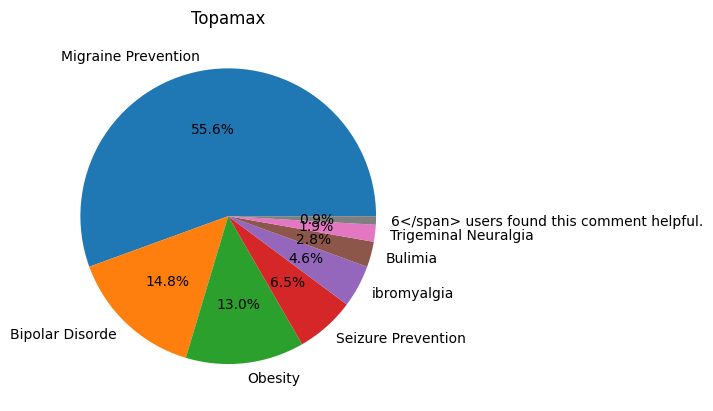

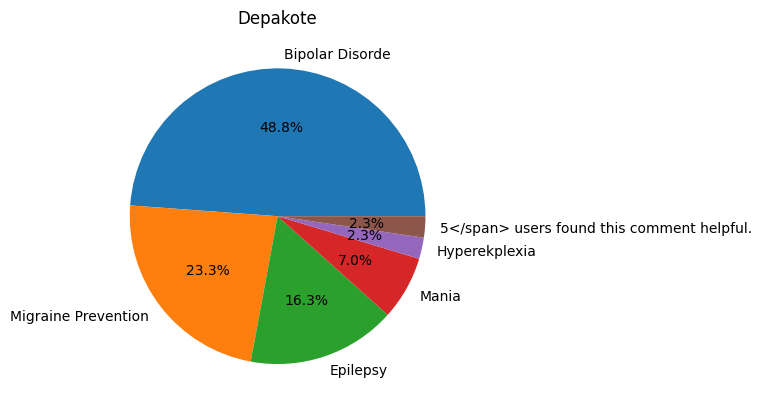

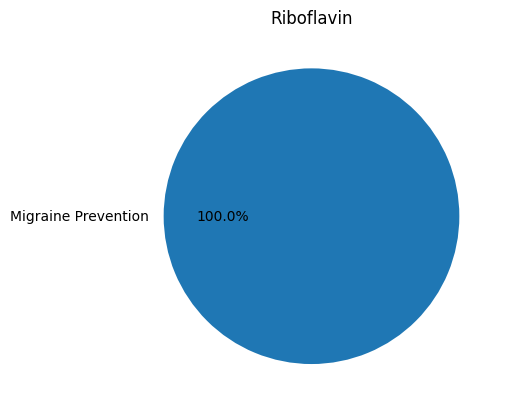

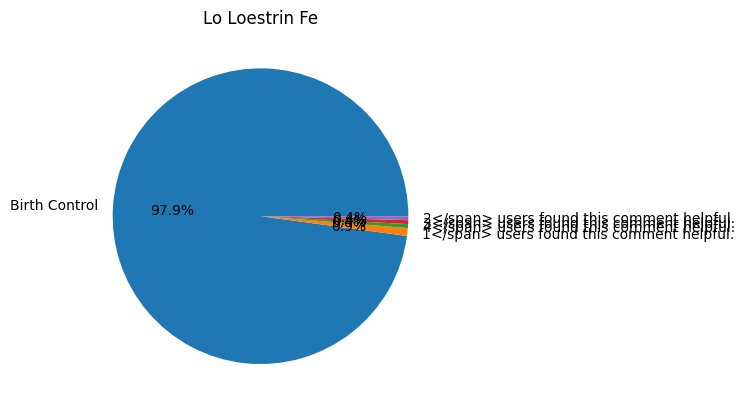

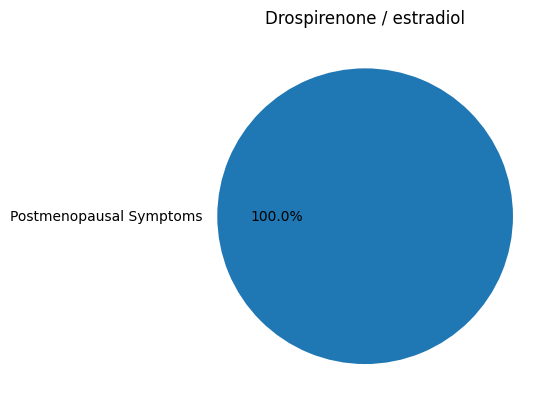

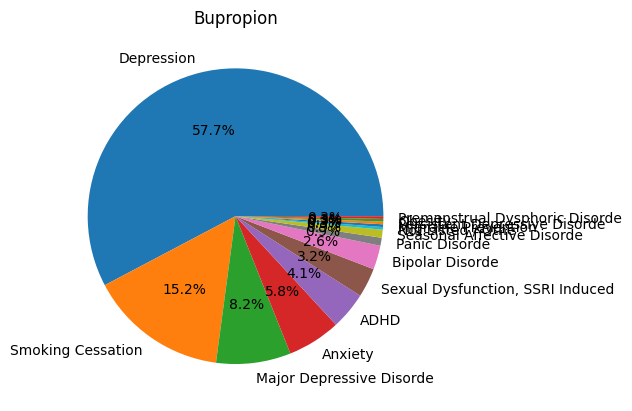

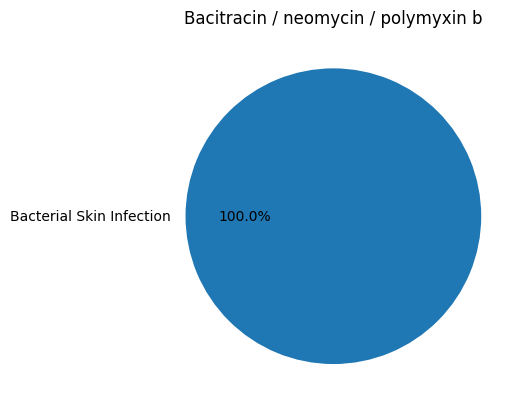

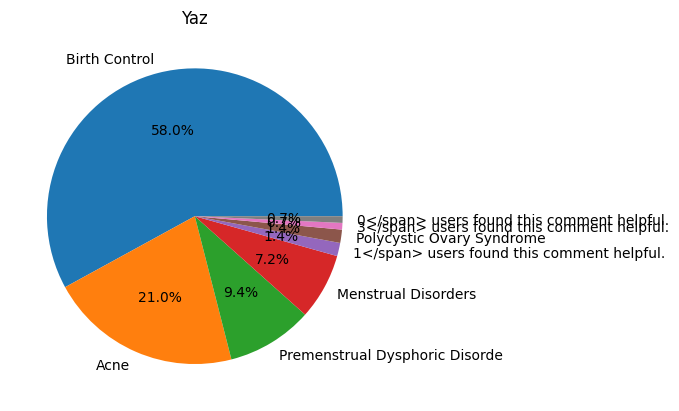

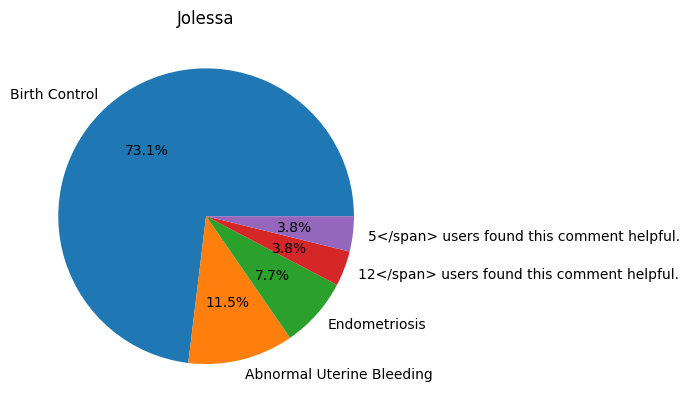

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
print("Drug <-- Conditions")

for d in drugs:
    df1 = df_test.loc[df_test["drugName"] == d]
    df1 = df1["condition"].value_counts().rename_axis("condition").reset_index(name="count")

    plt.pie(x = df1["count"], labels = df1["condition"], autopct = "%1.1f%%")
    plt.title(d)
    plt.show()

### Multiple Heatmaps for Drug Reccomendation based on Conditions

Drug <-- Conditions <-- Recommend (Yes / No)


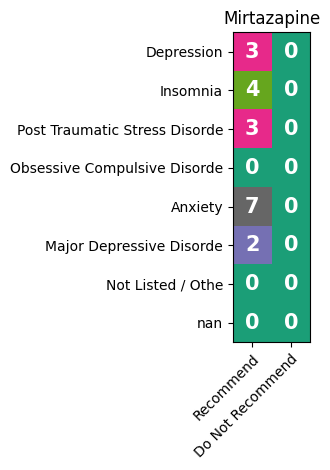

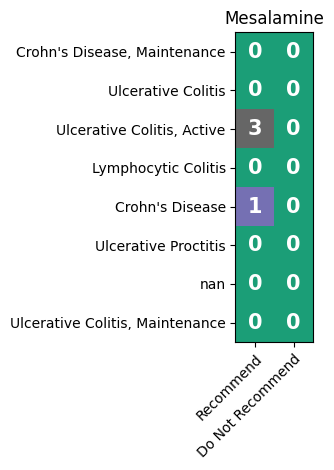

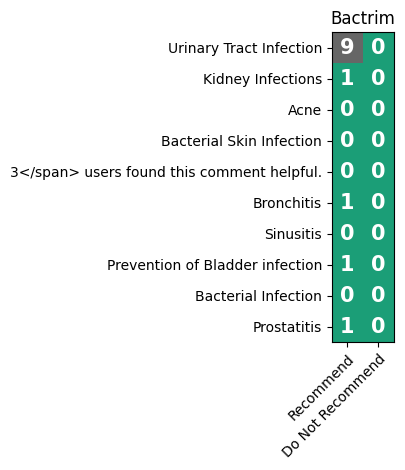

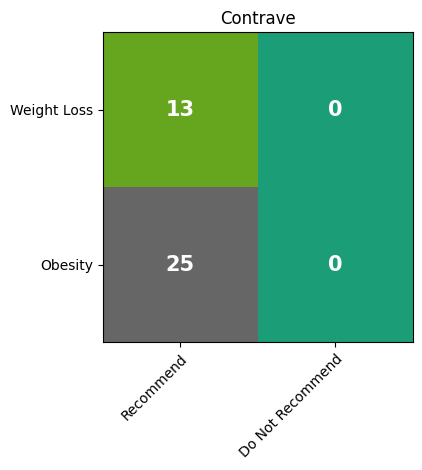

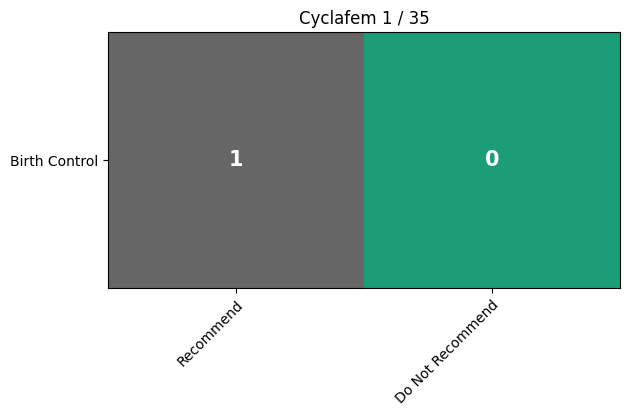

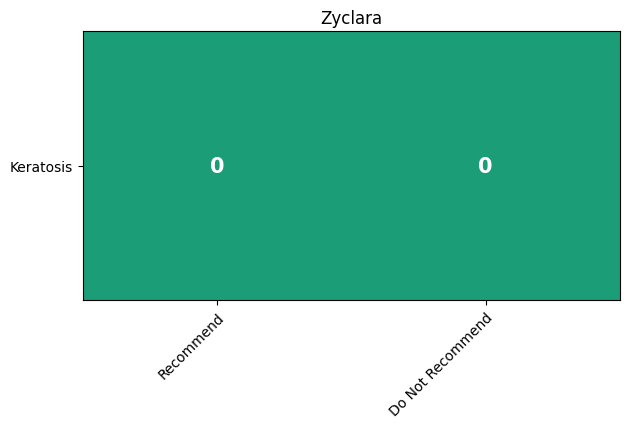

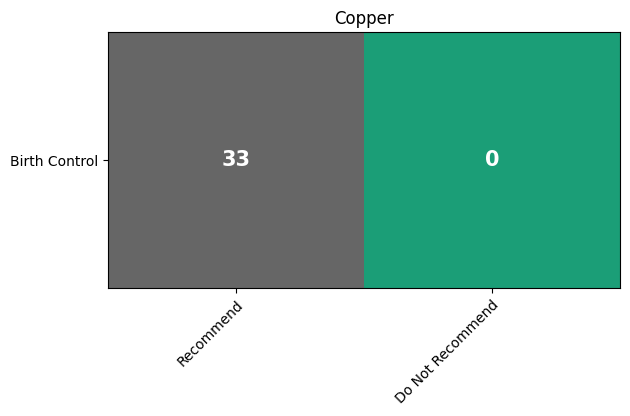

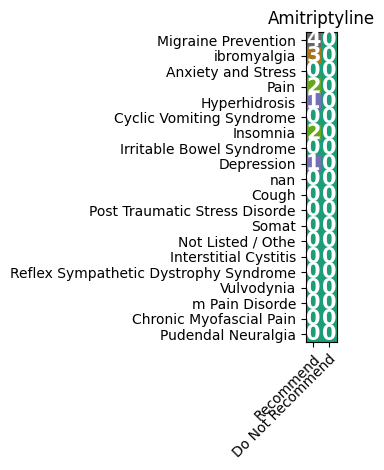

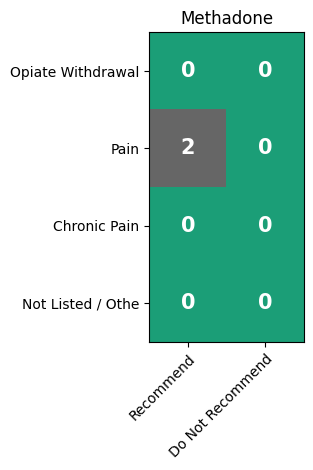

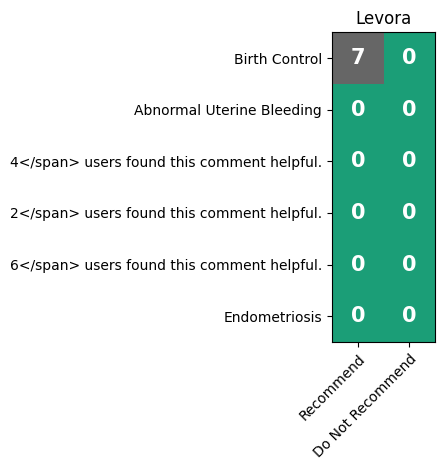

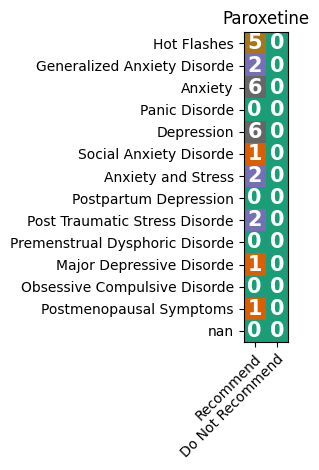

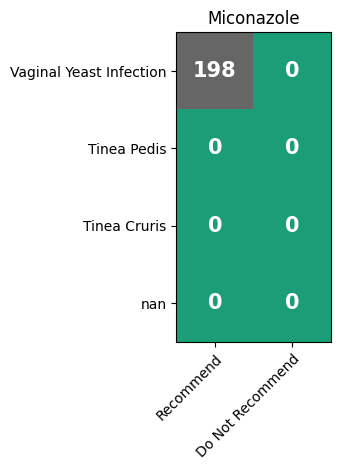

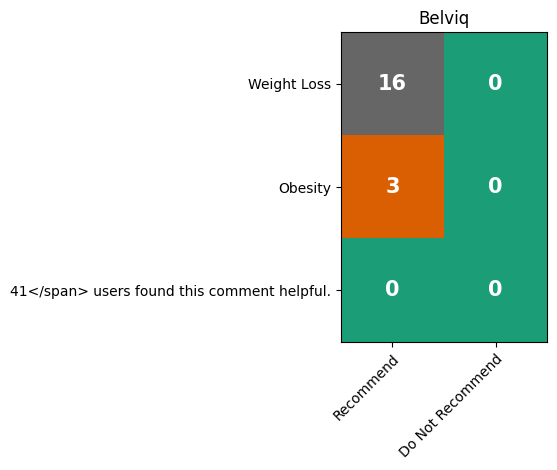

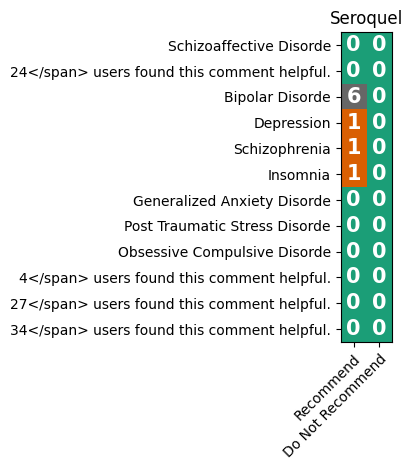

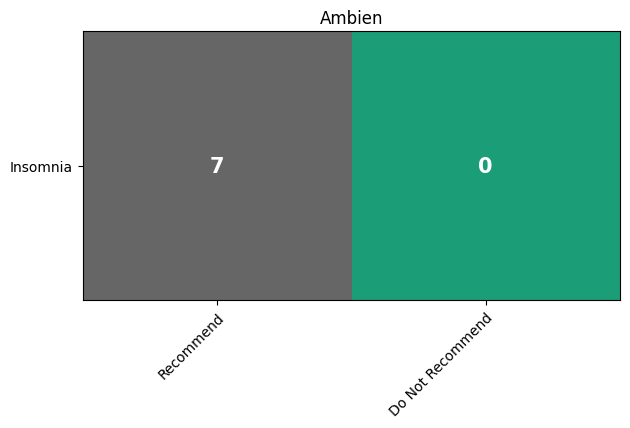

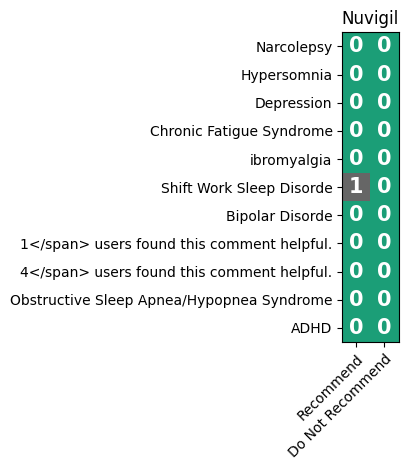

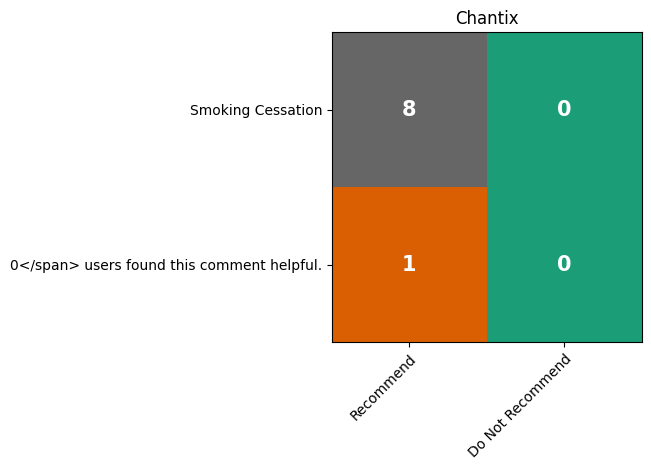

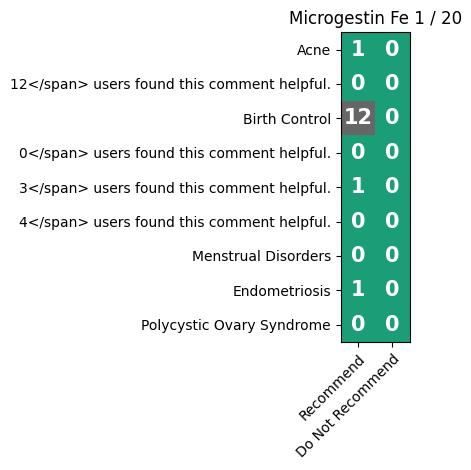

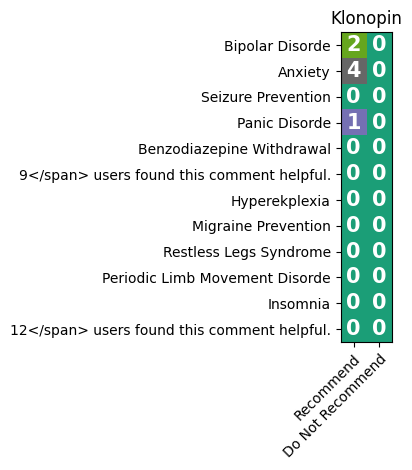

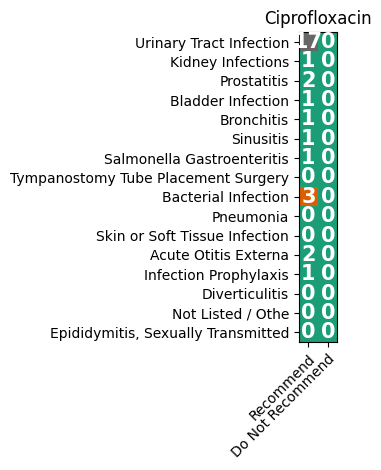

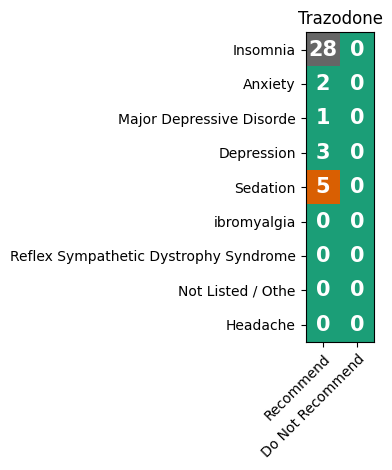

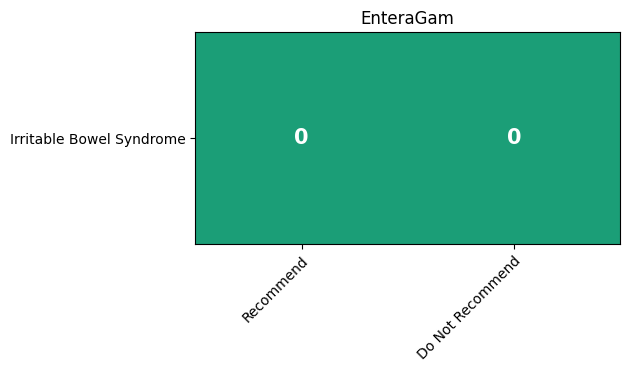

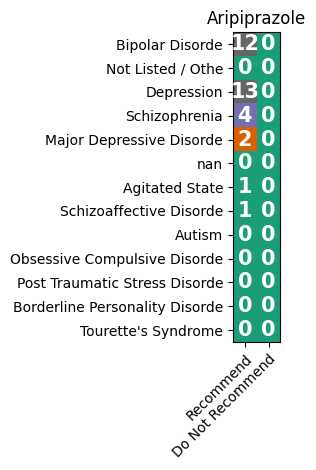

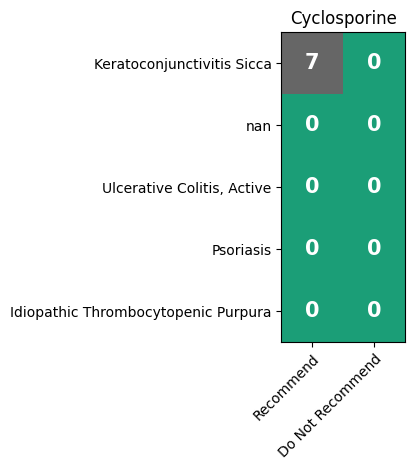

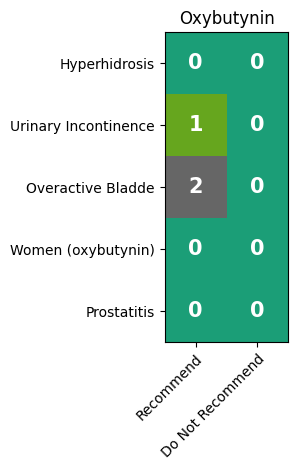

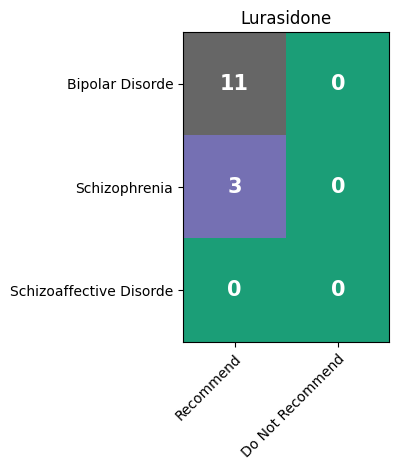

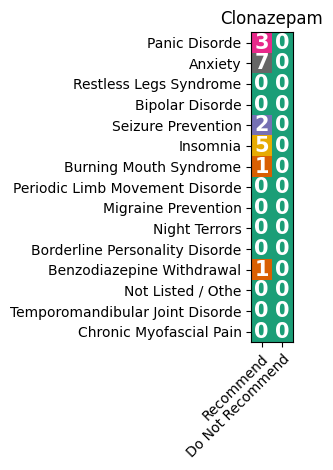

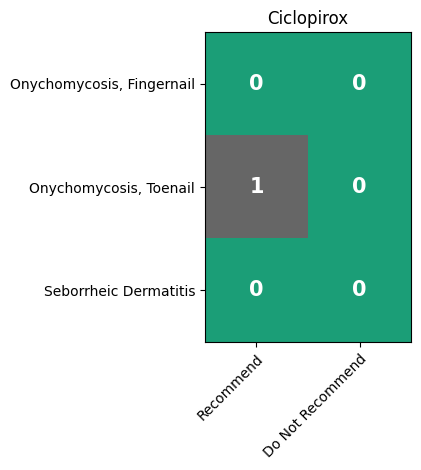

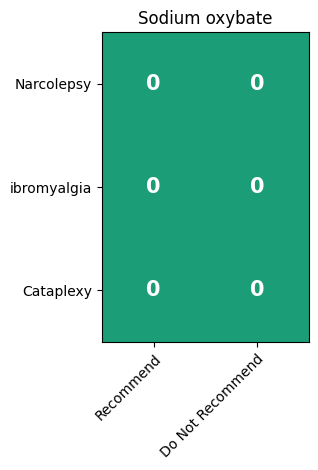

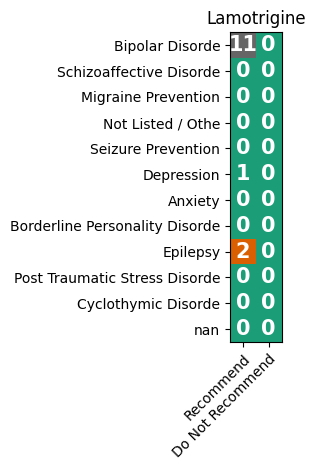

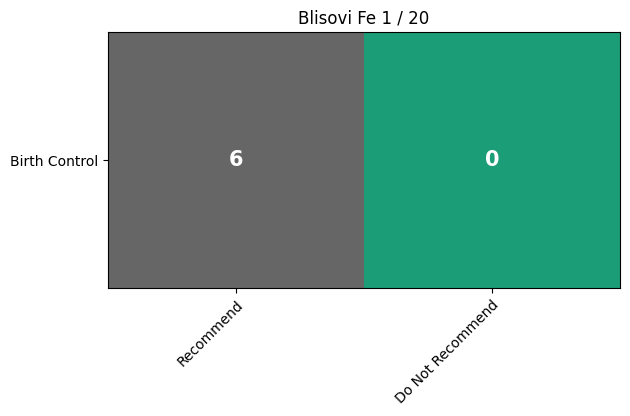

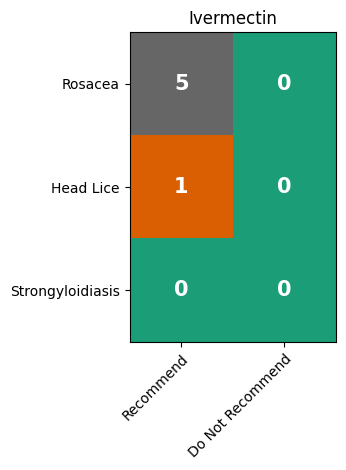

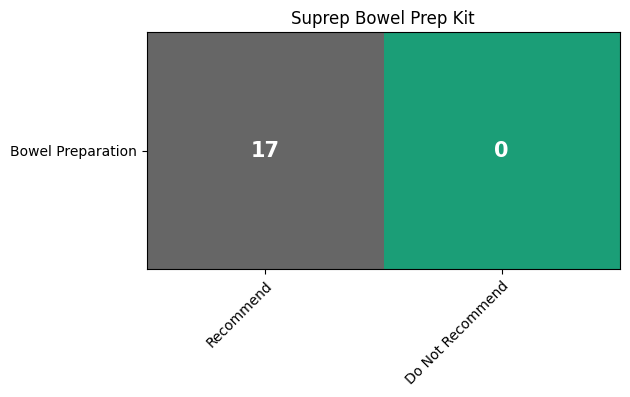

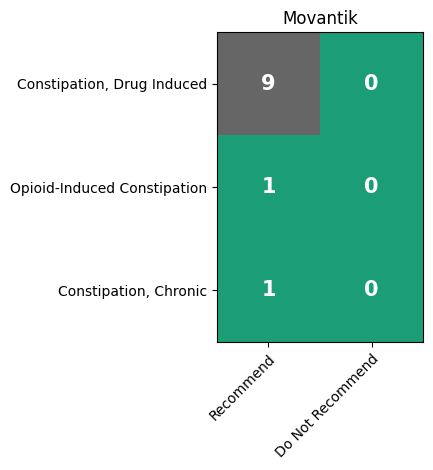

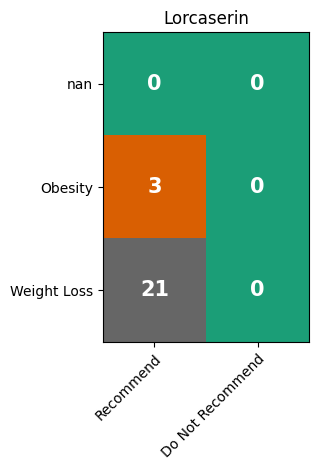

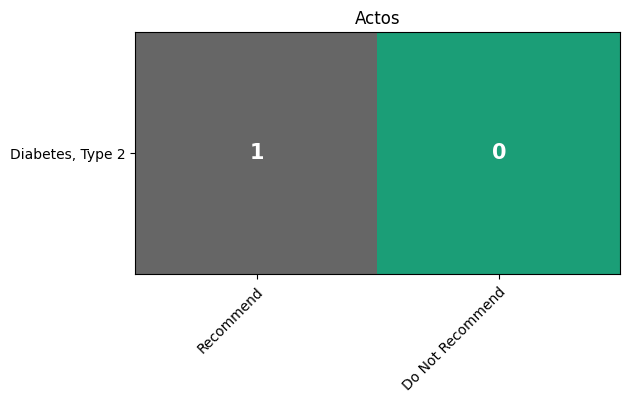

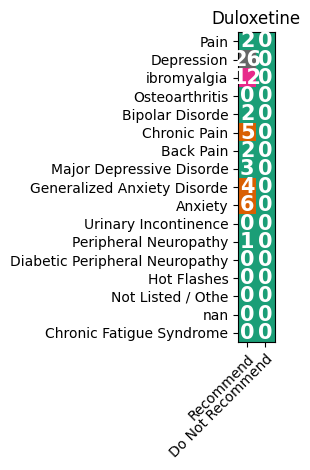

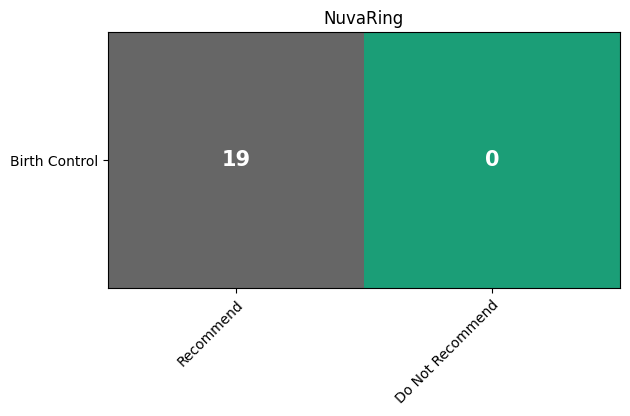

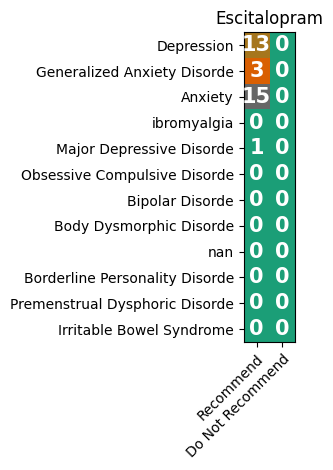

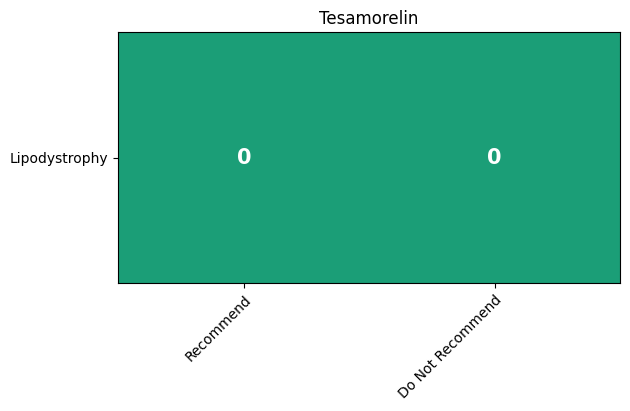

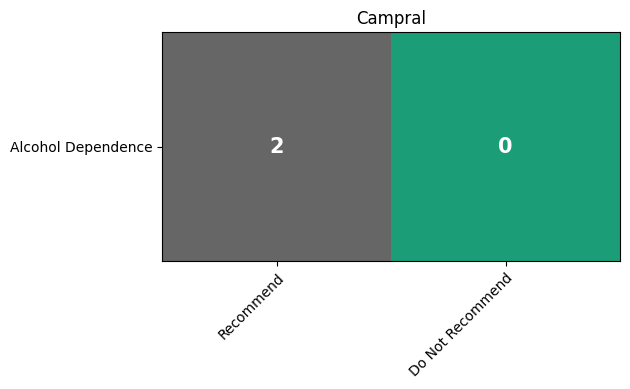

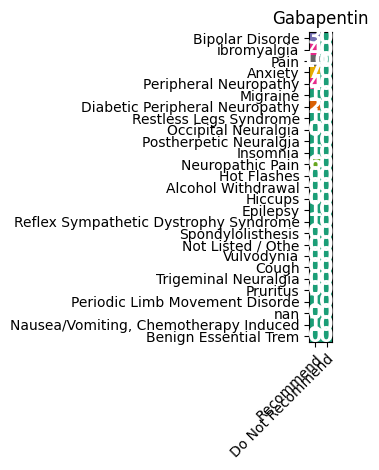

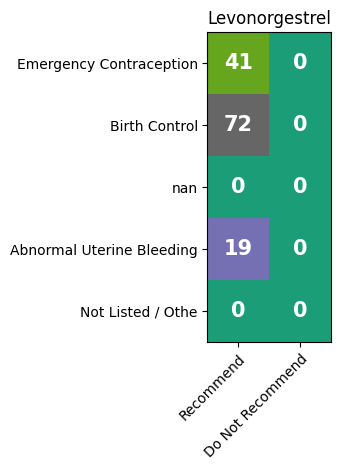

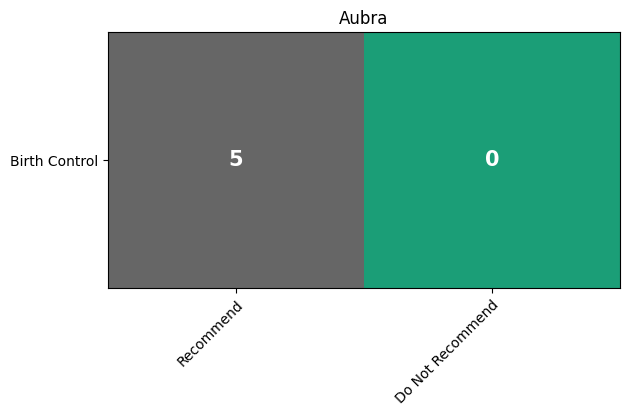

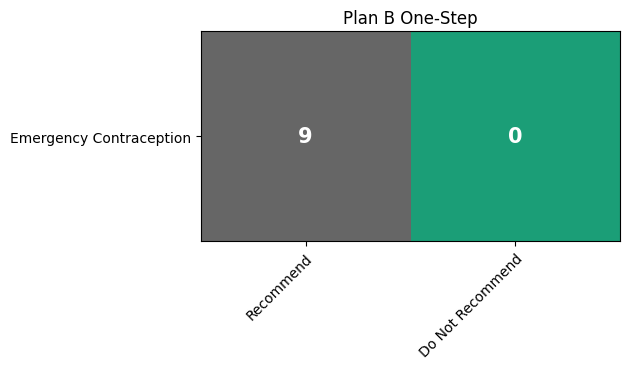

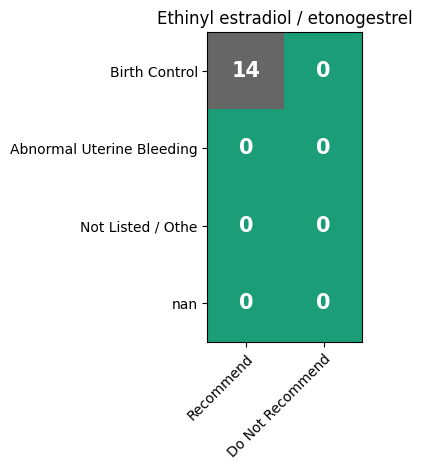

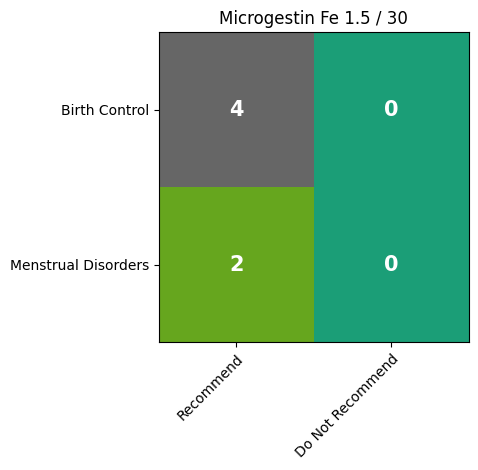

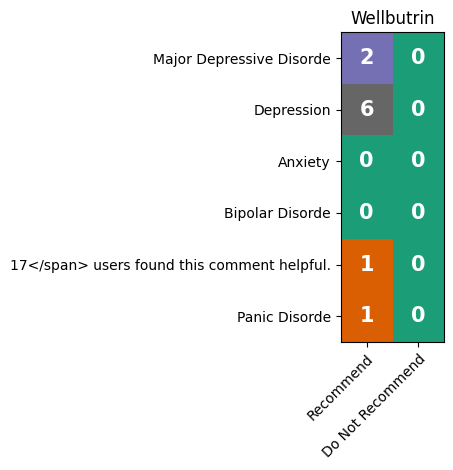

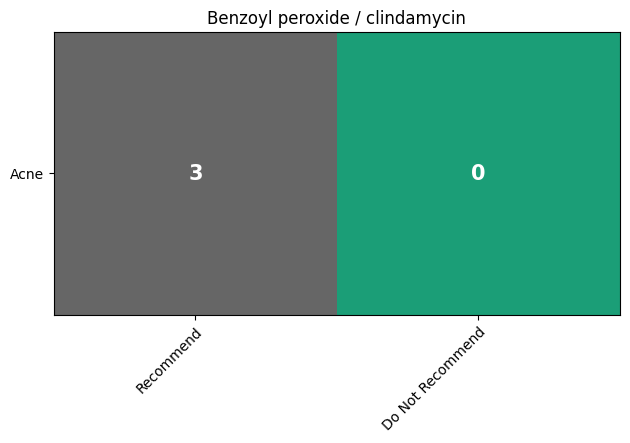

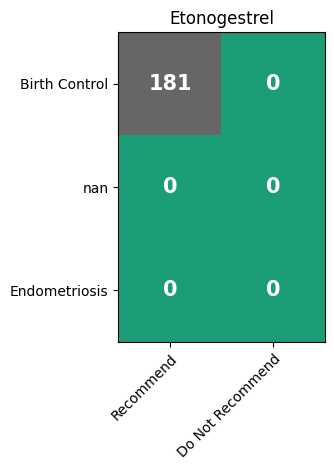

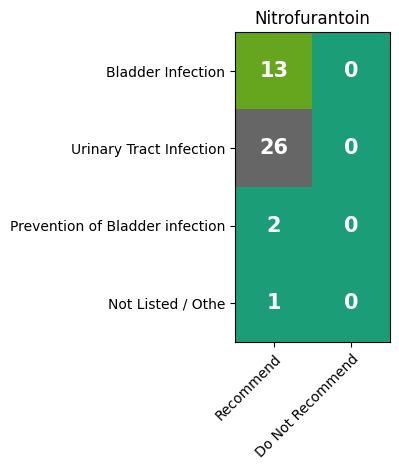

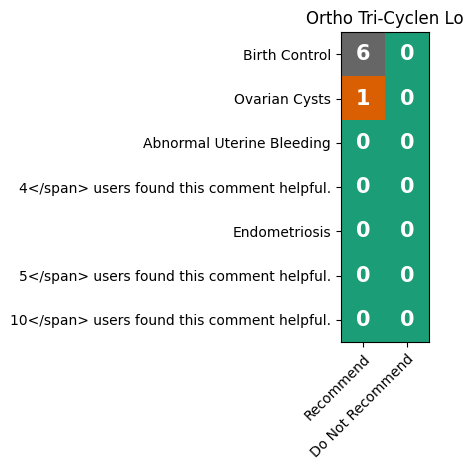

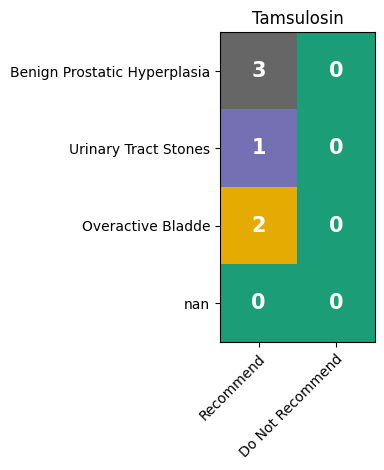

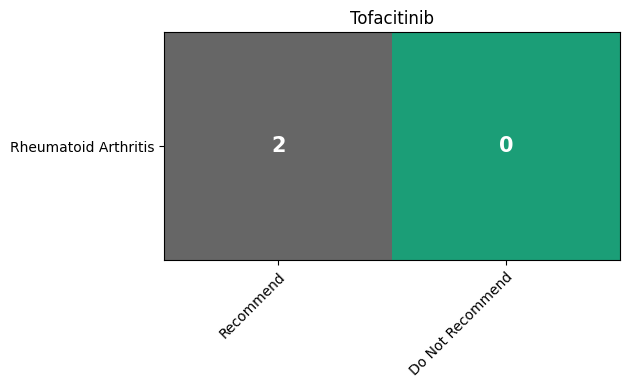

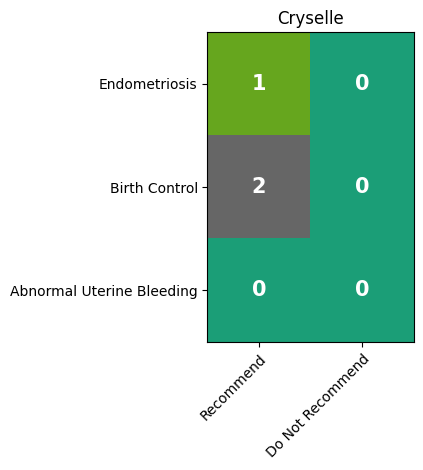

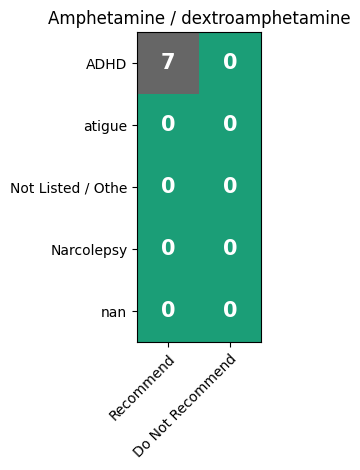

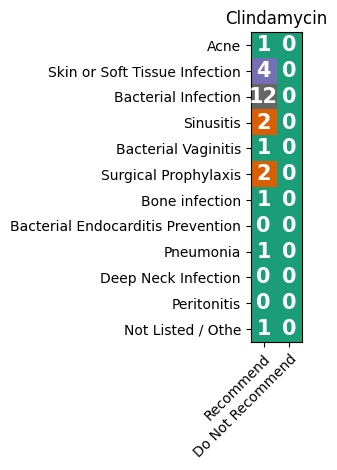

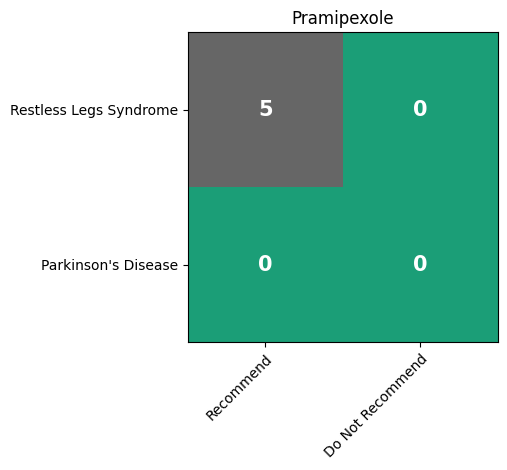

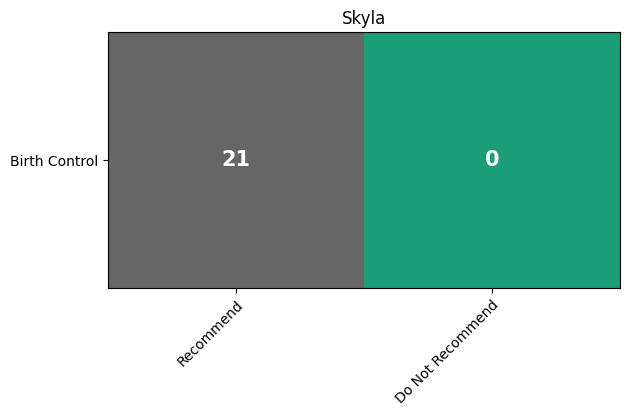

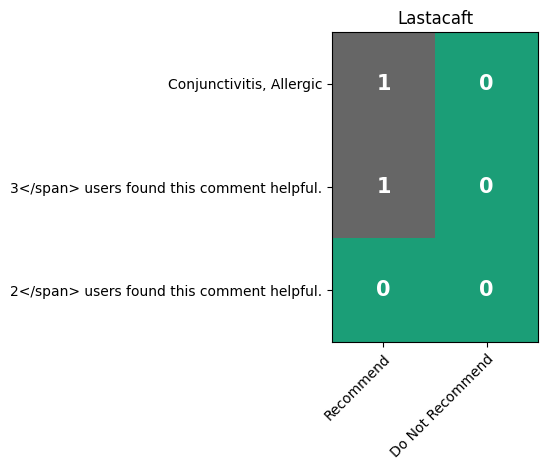

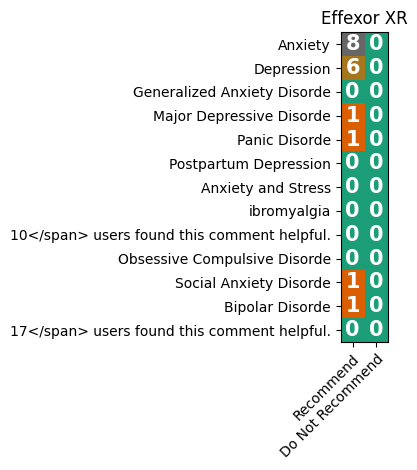

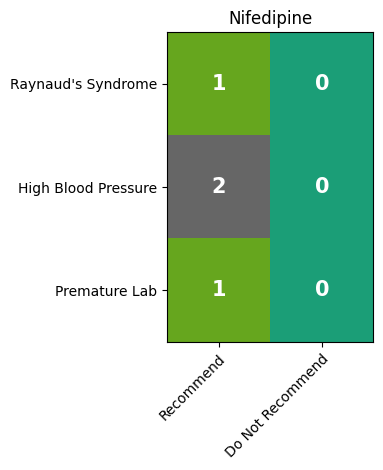

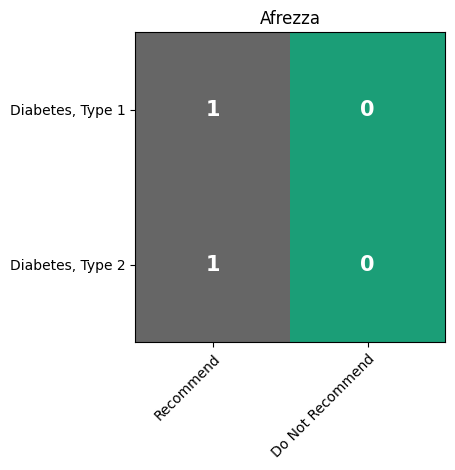

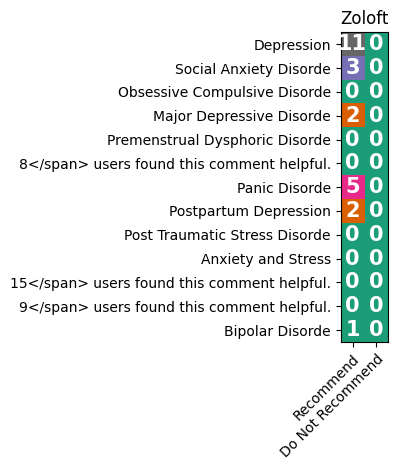

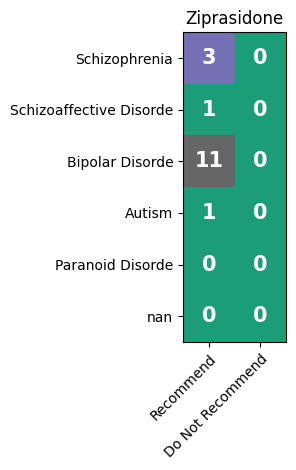

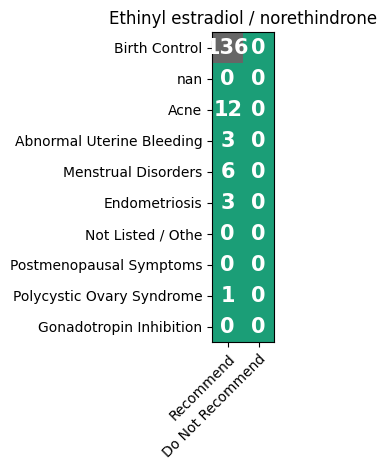

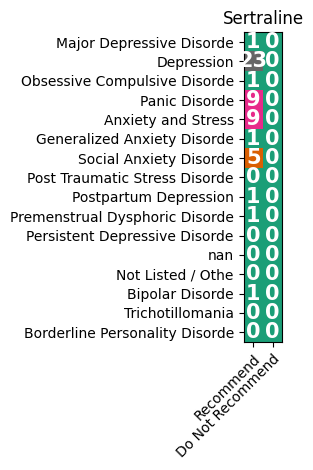

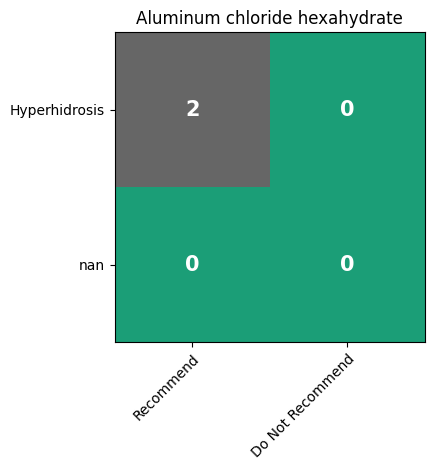

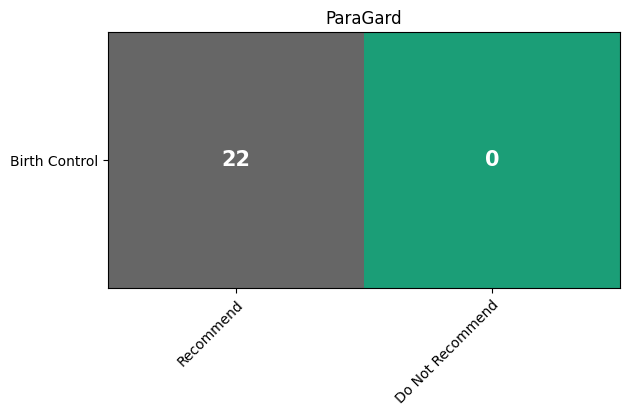

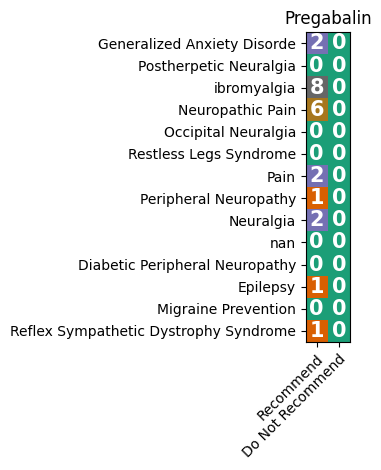

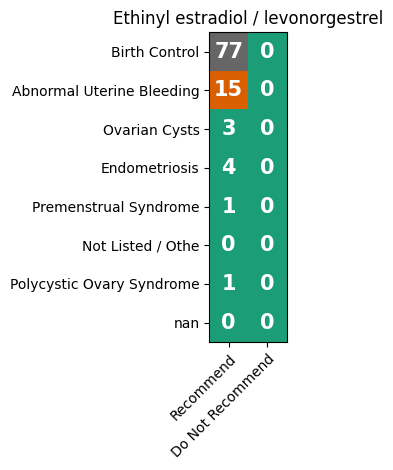

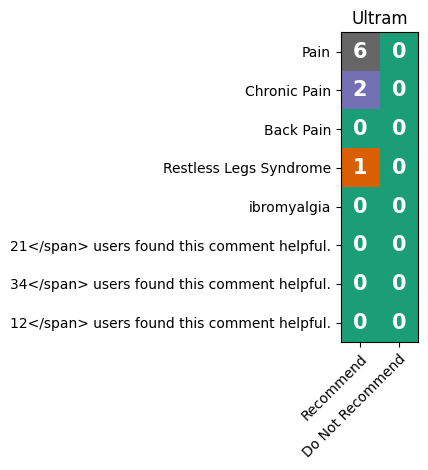

KeyboardInterrupt: 

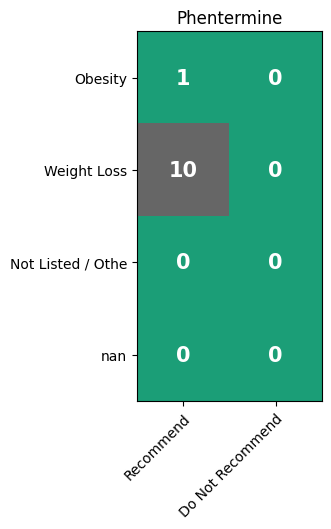

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select the first 5 drugs from the dataset
drugs = df_test['drugName'].unique()

print("Drug <-- Conditions <-- Recommend (Yes / No)")

for d in drugs:
    df2 = df_test.loc[df_test["drugName"] == d]
    conditions = df2["condition"].unique()

    Yes = []
    No = []

    for c in conditions:
        df3 = df2.loc[df2["condition"] == c]
        recommendation_counts = df3["rating"].value_counts()
        y = recommendation_counts.get(1, 0)
        n = recommendation_counts.get(0, 0)
        Yes.append(y)
        No.append(n)

    classes = ['Recommend', 'Do Not Recommend']
    vals = np.column_stack((Yes, No))

    fig, ax = plt.subplots()
    im = ax.imshow(vals, cmap="Dark2")
    ax.grid(False)

    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(conditions)))

    ax.set_xticklabels(classes)
    ax.set_yticklabels(conditions)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(conditions)):
        for j in range(len(classes)):
            text = ax.text(j, i, vals[i, j], ha="center", va="center", color="w", fontweight="bold", fontsize=15)

    ax.set_title(d)
    fig.tight_layout()
    plt.show()
